🚀 TradingSystem分析開始 - 銘柄: 7203.JP
Loading data for 7203.JP...
テクニカル指標計算後の列: ['SMA_5', 'SMA_25', 'SMA_75', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_25_2.0', 'BBM_25_2.0', 'BBU_25_2.0', 'BBB_25_2.0', 'BBP_25_2.0', 'ATRr_14']
Running simulation...
テクニカル指標計算後の列: ['SMA_5', 'SMA_25', 'SMA_75', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_25_2.0', 'BBM_25_2.0', 'BBU_25_2.0', 'BBB_25_2.0', 'BBP_25_2.0', 'ATRr_14']
Running simulation...

📈 シミュレーション結果

📊【取引履歴】
✅ [Signal (score: 2.5)] 24-08-26 買: 2,561 (score: 2.5) → 24-08-27 売: 2,604 | 数量: 194 | 損益: 3,378円
✅ [Signal (score: 2.5)] 24-09-19 買: 2,573 (score: 2.5) → 24-10-07 売: 2,644 | 数量: 193 | 損益: 8,608円
✅ [Signal (score: 3.8)] 24-10-08 買: 2,569 (score: 2.5) → 24-11-19 売: 2,729 | 数量: 195 | 損益: 26,005円
❌ [Signal (score: 2.5)] 24-11-20 買: 2,700 (score: 3.8) → 24-11-21 売: 2,673 | 数量: 191 | 損益: -10,228円
✅ [Signal (score: 4.5)] 24-11-22 買: 2,666 (score: 2.5) → 24-11-25 売: 2,693 | 数量: 191 | 損益: 100円
❌ [Stop Lo

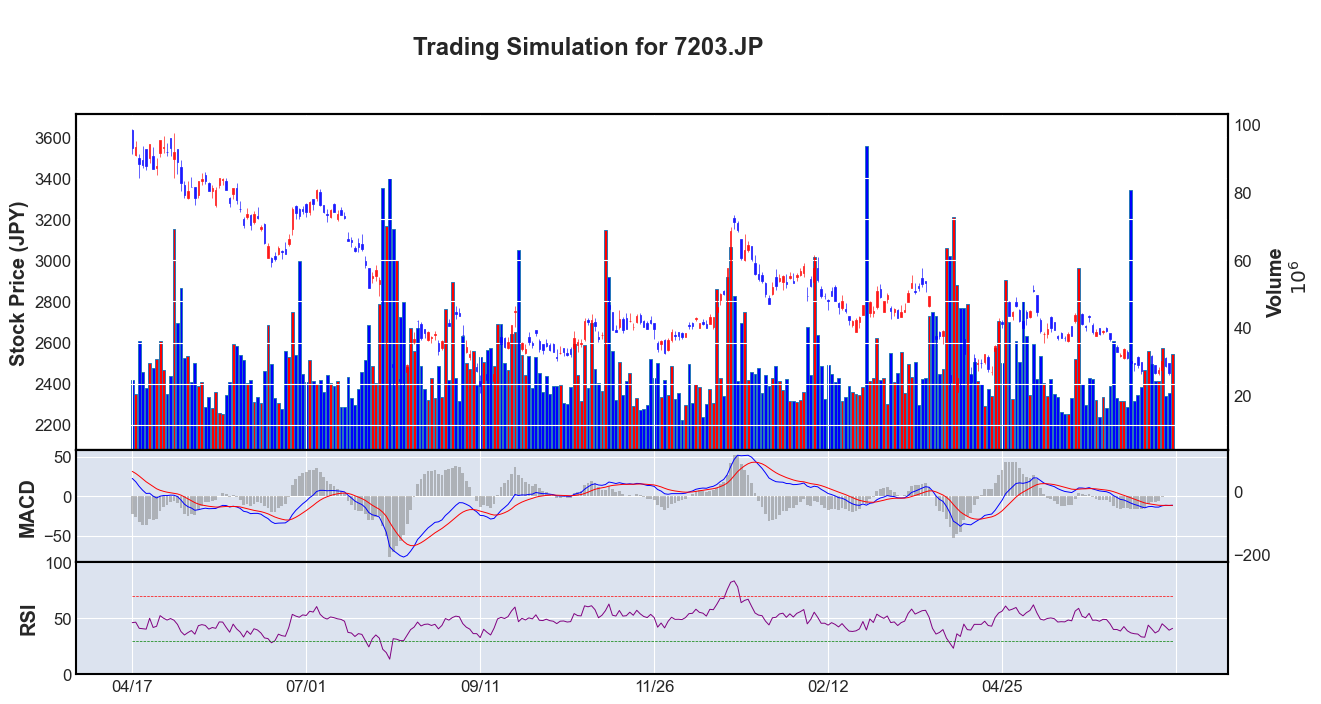

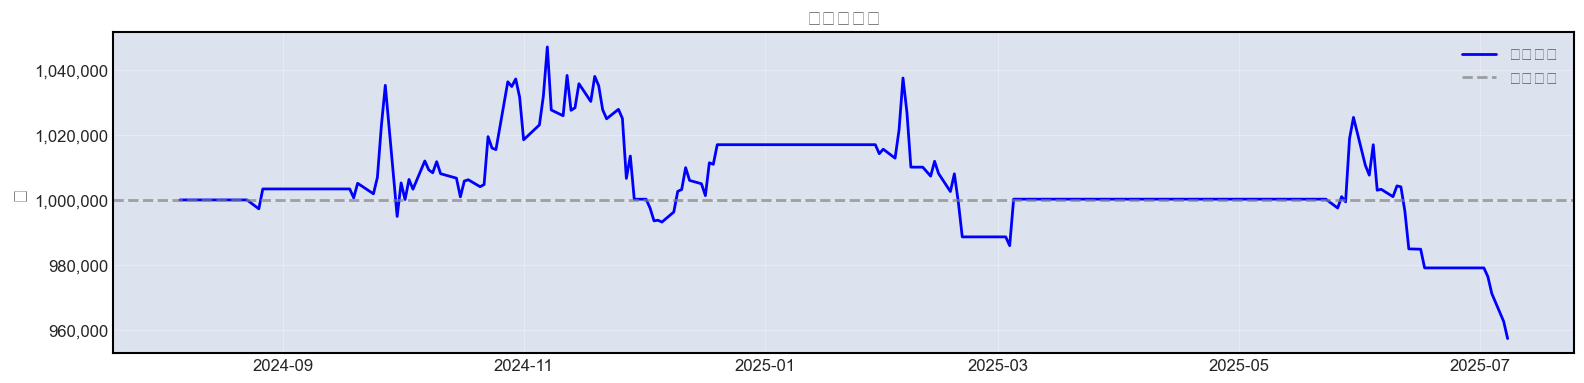


✅ 分析完了！


In [3]:
# --- 必要なライブラリ ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
from pandas_datareader import data
import warnings
import config

warnings.simplefilter('ignore')

# ==============================================================================
# --- 酒田五法の判定関数 ---
# ==============================================================================

def detect_double_top(prices, threshold=0.01):
    """ダブルトップ（三山）を検出"""
    if len(prices) < 3: return False
    peaks = (prices.shift(1) < prices) & (prices.shift(-1) < prices)
    peak_indexes = prices[peaks].index
    if len(peak_indexes) < 2: return False
    
    p1, p2 = peak_indexes[-2], peak_indexes[-1]
    valley = prices[p1:p2].min()
    
    # 2つの山がほぼ同じ高さで、中間の谷が十分低いか
    if abs(prices[p1] - prices[p2]) / prices[p1] < threshold and valley < prices[p1] * (1 - threshold):
        return True
    return False

def detect_double_bottom(prices, threshold=0.01):
    """ダブルボトム（三川）を検出"""
    if len(prices) < 3: return False
    troughs = (prices.shift(1) > prices) & (prices.shift(-1) > prices)
    trough_indexes = prices[troughs].index
    if len(trough_indexes) < 2: return False
    
    t1, t2 = trough_indexes[-2], trough_indexes[-1]
    peak = prices[t1:t2].max()
    
    # 2つの谷がほぼ同じ深さで、中間の山が十分高いか
    if abs(prices[t1] - prices[t2]) / prices[t1] < threshold and peak > prices[t1] * (1 + threshold):
        return True
    return False

def detect_three_gap_up(df_window):
    """三空踏み上げを検出（直近5日間で判定）"""
    if len(df_window) < 4: return False
    gaps_up = 0
    for i in range(1, len(df_window)):
        # 窓を開けて上昇
        if df_window['Low'].iloc[i] > df_window['High'].iloc[i-1]:
            gaps_up += 1
    return gaps_up >= 3

def detect_three_gap_down(df_window):
    """三空叩き込みを検出（直近5日間で判定）"""
    if len(df_window) < 4: return False
    gaps_down = 0
    for i in range(1, len(df_window)):
        # 窓を開けて下落
        if df_window['High'].iloc[i] < df_window['Low'].iloc[i-1]:
            gaps_down += 1
    return gaps_down >= 3

def detect_three_white_soldiers(df_window):
    """赤三兵を検出（直近3日間）"""
    if len(df_window) != 3: return False
    # 3日連続で陽線
    is_all_positive = (df_window['Close'] > df_window['Open']).all()
    # 終値が日に日に上昇
    is_closing_up = (df_window['Close'].diff().dropna() > 0).all()
    # 始値が前日の実体の範囲内にある
    is_opening_in_body = (df_window['Open'].iloc[1] > df_window['Open'].iloc[0]) and \
                         (df_window['Open'].iloc[1] < df_window['Close'].iloc[0]) and \
                         (df_window['Open'].iloc[2] > df_window['Open'].iloc[1]) and \
                         (df_window['Open'].iloc[2] < df_window['Close'].iloc[1])
    return is_all_positive and is_closing_up and is_opening_in_body

def detect_three_black_crows(df_window):
    """黒三兵（三羽烏）を検出（直近3日間）"""
    if len(df_window) != 3: return False
    # 3日連続で陰線
    is_all_negative = (df_window['Close'] < df_window['Open']).all()
    # 終値が日に日に下落
    is_closing_down = (df_window['Close'].diff().dropna() < 0).all()
    # 始値が前日の実体の範囲内にある
    is_opening_in_body = (df_window['Open'].iloc[1] < df_window['Open'].iloc[0]) and \
                         (df_window['Open'].iloc[1] > df_window['Close'].iloc[0]) and \
                         (df_window['Open'].iloc[2] < df_window['Open'].iloc[1]) and \
                         (df_window['Open'].iloc[2] > df_window['Close'].iloc[1])
    return is_all_negative and is_closing_down and is_opening_in_body


# ==============================================================================
# --- TradingSystemクラス ---
# ==============================================================================

class TradingSystem:
    """株式取引システムのメインクラス"""
    
    def __init__(self, stock_code=None):
        """
        TradingSystemの初期化
        
        Args:
            stock_code (str, optional): 銘柄コード。Noneの場合はconfig.pyの設定を使用
        """
        # 設定項目の読み込み
        self.stock_code = stock_code or config.STOCK_CODE
        self.data_period_days = config.DATA_PERIOD_DAYS
        self.initial_cash = config.INITIAL_CASH
        self.investment_ratio = config.INVESTMENT_RATIO
        self.fee_rate = config.FEE_RATE
        self.slippage_rate = config.SLIPPAGE_RATE
        self.take_profit_atr_multiple = config.TAKE_PROFIT_ATR_MULTIPLE
        self.stop_loss_atr_multiple = config.STOP_LOSS_ATR_MULTIPLE
        self.take_profit_rate = config.TAKE_PROFIT_RATE
        self.stop_loss_rate = config.STOP_LOSS_RATE
        self.buy_threshold = config.BUY_THRESHOLD
        self.sell_threshold = config.SELL_THRESHOLD
        self.signal_weights = config.SIGNAL_WEIGHTS
        
        # 状態変数の初期化
        self.df = None
        self.asset_history = []
        self.trade_history = []
        self.final_cash = 0.0
    
    def prepare_data(self):
        """株価データを取得し、テクニカル指標を計算する"""
        print(f"Loading data for {self.stock_code}...")
        try:
            df = data.DataReader(self.stock_code, 'stooq')
            if df.empty:
                print(f"エラー: {self.stock_code} のデータが見つかりません。")
                return None
        except Exception as e:
            print(f"データ取得エラー: {e}")
            return None
            
        df = df.sort_index()

        # pandas_taを使用してテクニカル指標を計算
        df.ta.sma(length=5, append=True)
        df.ta.sma(length=25, append=True)
        df.ta.sma(length=75, append=True)
        df.ta.rsi(length=14, append=True)
        df.ta.macd(fast=12, slow=26, signal=9, append=True)
        df.ta.bbands(length=25, std=2, append=True)
        df.ta.atr(length=14, append=True)
        
        # 不要なカラムを削除する前に統一カラムの存在確認
        print("テクニカル指標計算後の列:", [col for col in df.columns if any(x in col for x in ['SMA', 'RSI', 'MACD', 'BB', 'ATR'])])
        
        # カラム名を統一（実際に存在する列のみ）
        if 'SMA_5' in df.columns:
            df['sma5'] = df['SMA_5']
        if 'SMA_25' in df.columns:
            df['sma25'] = df['SMA_25']
        if 'SMA_75' in df.columns:
            df['sma75'] = df['SMA_75']
        else:
            # SMA_75が計算されていない場合、手動で計算
            df['sma75'] = df['Close'].rolling(window=75).mean()
        if 'RSI_14' in df.columns:
            df['RSI'] = df['RSI_14']
        if 'MACD_12_26_9' in df.columns:
            df['MACD'] = df['MACD_12_26_9']
        if 'MACDs_12_26_9' in df.columns:
            df['MACD_signal'] = df['MACDs_12_26_9']
        if 'MACDh_12_26_9' in df.columns:
            df['MACD_hist'] = df['MACDh_12_26_9']
        if 'BBU_25_2.0' in df.columns:
            df['BB_upper'] = df['BBU_25_2.0']
        if 'BBM_25_2.0' in df.columns:
            df['BB_middle'] = df['BBM_25_2.0']
        if 'BBL_25_2.0' in df.columns:
            df['BB_lower'] = df['BBL_25_2.0']
        if 'ATRr_14' in df.columns:
            df['ATR'] = df['ATRr_14']
        
        # 必要な列が存在するかチェック
        required_cols = ['sma5', 'sma25', 'sma75', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 
                        'BB_upper', 'BB_middle', 'BB_lower', 'ATR']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"警告: 以下の列が見つかりません: {missing_cols}")
        
        # 不要なカラムを削除
        cols_to_drop = [col for col in df.columns if col.startswith(('SMA_', 'RSI_', 'MACD', 'BB', 'ATR')) 
                        and col not in ['RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'ATR']]
        df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
        
        # データを指定期間に絞り、欠損値がある行を削除
        df = df.tail(self.data_period_days).dropna()
        self.df = df
        return df
    
    def evaluate_buy_signals(self, df_hist, current_idx):
        """
        過去データのみを使用して買いシグナルを評価
        df_hist: current_idxまでの過去データ
        current_idx: 現在のインデックス（実際の取引実行日）
        """
        buy_signal_score = 0.0
        
        if len(df_hist) < 75:  # 最低限必要なデータ数
            return buy_signal_score
        
        # 前日（i-1）時点のデータを使用
        prev_day = df_hist.iloc[-1]
        prev_day_2 = df_hist.iloc[-2] if len(df_hist) >= 2 else None
        
        # テクニカル指標シグナル
        if prev_day_2 is not None:
            # ゴールデンクロス（短期）
            if ('sma5' in df_hist.columns and 'sma25' in df_hist.columns and
                prev_day_2['sma5'] < prev_day_2['sma25'] and 
                prev_day['sma5'] > prev_day['sma25']):
                buy_signal_score += self.signal_weights['golden_cross_short']
            
            # ゴールデンクロス（長期）
            if ('sma25' in df_hist.columns and 'sma75' in df_hist.columns and
                prev_day_2['sma25'] < prev_day_2['sma75'] and 
                prev_day['sma25'] > prev_day['sma75']):
                buy_signal_score += self.signal_weights['golden_cross_long']
            
            # MACDブリッシュクロス
            if ('MACD' in df_hist.columns and 'MACD_signal' in df_hist.columns and
                prev_day_2['MACD'] < prev_day_2['MACD_signal'] and 
                prev_day['MACD'] > prev_day['MACD_signal']):
                buy_signal_score += self.signal_weights['macd_bullish']
        
        # ボリンジャーバンド下限突破
        if 'BB_lower' in df_hist.columns and prev_day['Close'] < prev_day['BB_lower']:
            buy_signal_score += self.signal_weights['bb_oversold']
        
        # RSI売られすぎ
        if 'RSI' in df_hist.columns and prev_day['RSI'] < 30:
            buy_signal_score += self.signal_weights['rsi_oversold']
        
        # 酒田五法シグナル（過去データのみ使用）
        if len(df_hist) >= 20:
            prices_hist = df_hist['Close'].iloc[-20:]  # 過去20日分
            if detect_double_bottom(prices_hist):
                buy_signal_score += self.signal_weights['double_bottom']
        
        if len(df_hist) >= 3:
            df_3days = df_hist.iloc[-3:]
            if detect_three_white_soldiers(df_3days):
                buy_signal_score += self.signal_weights['three_white_soldiers']
        
        if len(df_hist) >= 5:
            df_5days = df_hist.iloc[-5:]
            if detect_three_gap_down(df_5days):
                buy_signal_score += self.signal_weights['three_gap_down']
        
        return buy_signal_score

    def evaluate_sell_signals(self, df_hist, current_idx):
        """
        過去データのみを使用して売りシグナルを評価
        df_hist: current_idxまでの過去データ
        current_idx: 現在のインデックス（実際の取引実行日）
        """
        sell_signal_score = 0.0
        
        if len(df_hist) < 75:  # 最低限必要なデータ数
            return sell_signal_score
        
        # 前日（i-1）時点のデータを使用
        prev_day = df_hist.iloc[-1]
        prev_day_2 = df_hist.iloc[-2] if len(df_hist) >= 2 else None
        
        # テクニカル指標シグナル
        if prev_day_2 is not None:
            # デッドクロス（短期）
            if ('sma5' in df_hist.columns and 'sma25' in df_hist.columns and
                prev_day_2['sma5'] > prev_day_2['sma25'] and 
                prev_day['sma5'] < prev_day['sma25']):
                sell_signal_score += self.signal_weights['dead_cross_short']
            
            # デッドクロス（長期）
            if ('sma25' in df_hist.columns and 'sma75' in df_hist.columns and
                prev_day_2['sma25'] > prev_day_2['sma75'] and 
                prev_day['sma25'] < prev_day['sma75']):
                sell_signal_score += self.signal_weights['dead_cross_long']
            
            # MACDベアリッシュクロス
            if ('MACD' in df_hist.columns and 'MACD_signal' in df_hist.columns and
                prev_day_2['MACD'] > prev_day_2['MACD_signal'] and 
                prev_day['MACD'] < prev_day['MACD_signal']):
                sell_signal_score += self.signal_weights['macd_bearish']
        
        # ボリンジャーバンド上限突破
        if 'BB_upper' in df_hist.columns and prev_day['Close'] > prev_day['BB_upper']:
            sell_signal_score += self.signal_weights['bb_overbought']
        
        # RSI買われすぎ
        if 'RSI' in df_hist.columns and prev_day['RSI'] > 70:
            sell_signal_score += self.signal_weights['rsi_overbought']
        
        # 酒田五法シグナル（過去データのみ使用）
        if len(df_hist) >= 20:
            prices_hist = df_hist['Close'].iloc[-20:]  # 過去20日分
            if detect_double_top(prices_hist):
                sell_signal_score += self.signal_weights['double_top']
        
        if len(df_hist) >= 3:
            df_3days = df_hist.iloc[-3:]
            if detect_three_black_crows(df_3days):
                sell_signal_score += self.signal_weights['three_black_crows']
        
        if len(df_hist) >= 5:
            df_5days = df_hist.iloc[-5:]
            if detect_three_gap_up(df_5days):
                sell_signal_score += self.signal_weights['three_gap_up']
        
        return sell_signal_score

    def run_simulation(self):
        """シグナルに基づき売買シミュレーションを実行する（ルックアヘッドバイアス排除版）"""
        if self.df is None:
            print("エラー: データが準備されていません。prepare_data()を先に実行してください。")
            return None, None, 0.0
        
        cash = self.initial_cash
        position = 0
        buy_price = 0.0
        buy_atr = 0.0  # 購入時のATR
        in_position = False
        asset_history = []
        trade_history = []

        print("Running simulation...")
        
        # 最低限必要なデータ数を確保
        start_idx = max(75, len(self.df) // 4)  # 全データの1/4以降から開始
        
        for i in range(start_idx, len(self.df)):
            today = self.df.index[i]
            today_data = self.df.iloc[i]
            
            # 過去データのみを使用（i日目のデータは含まない）
            df_hist = self.df.iloc[0:i]
            
            # 売買執行価格（スリッページ考慮）
            execution_price_buy = today_data['Close'] * (1 + self.slippage_rate)
            execution_price_sell = today_data['Close'] * (1 - self.slippage_rate)

            # --- シグナル評価（過去データのみ使用） ---
            buy_signal_score = self.evaluate_buy_signals(df_hist, i)
            sell_signal_score = self.evaluate_sell_signals(df_hist, i)

            # --- 売買判断 ---
            if not in_position:
                # 買い判断
                if buy_signal_score >= self.buy_threshold:
                    invest_amount = cash * self.investment_ratio
                    qty_to_buy = int(invest_amount / (execution_price_buy * (1 + self.fee_rate)))
                    
                    if qty_to_buy * execution_price_buy * (1 + self.fee_rate) <= cash and qty_to_buy > 0:
                        position = qty_to_buy
                        cash -= position * execution_price_buy * (1 + self.fee_rate)
                        buy_price = execution_price_buy
                        buy_atr = df_hist.iloc[-1]['ATR'] if len(df_hist) > 0 else 0  # 購入時のATR
                        in_position = True
                        trade_history.append({
                            'type': 'BUY', 
                            'date': today, 
                            'price': execution_price_buy, 
                            'qty': position,
                            'signal_score': buy_signal_score
                        })
            else:
                # 売り判断（シグナル or 利食い or 損切り）
                sell_reason = None
                
                # シグナルによる売り判断
                if sell_signal_score >= self.sell_threshold:
                    sell_reason = f'Signal (score: {sell_signal_score:.1f})'
                else:
                    # ATRベースの利食い・損切り判定
                    if self.take_profit_atr_multiple > 0 and buy_atr > 0:
                        take_profit_price = buy_price + (buy_atr * self.take_profit_atr_multiple)
                        if today_data['Close'] >= take_profit_price:
                            sell_reason = f'Take Profit (ATR x{self.take_profit_atr_multiple})'
                    
                    if self.stop_loss_atr_multiple > 0 and buy_atr > 0:
                        stop_loss_price = buy_price - (buy_atr * self.stop_loss_atr_multiple)
                        if today_data['Close'] <= stop_loss_price:
                            sell_reason = f'Stop Loss (ATR x{self.stop_loss_atr_multiple})'
                    
                    # ATR設定が無効な場合、固定率を使用
                    if not sell_reason:
                        if self.take_profit_rate > 0:
                            take_profit_price = buy_price * (1 + self.take_profit_rate)
                            if today_data['Close'] >= take_profit_price:
                                sell_reason = f'Take Profit ({self.take_profit_rate*100:.1f}%)'
                        
                        if self.stop_loss_rate > 0:
                            stop_loss_price = buy_price * (1 - self.stop_loss_rate)
                            if today_data['Close'] <= stop_loss_price:
                                sell_reason = f'Stop Loss ({self.stop_loss_rate*100:.1f}%)'

                if sell_reason:
                    cash += position * execution_price_sell * (1 - self.fee_rate)
                    trade_history.append({
                        'type': 'SELL', 
                        'date': today, 
                        'price': execution_price_sell, 
                        'qty': position, 
                        'reason': sell_reason
                    })
                    position = 0
                    buy_price = 0.0
                    buy_atr = 0.0
                    in_position = False

            # 資産評価
            current_asset = cash + (position * today_data['Close'] if in_position else 0)
            asset_history.append((today, current_asset))

        # 最終日にポジションがあれば強制決済
        if in_position:
            final_price = self.df['Close'].iloc[-1] * (1 - self.slippage_rate)  # スリッページ考慮
            cash += position * final_price * (1 - self.fee_rate)
            trade_history.append({
                'type': 'SELL', 
                'date': self.df.index[-1], 
                'price': final_price, 
                'qty': position, 
                'reason': 'End of Simulation'
            })
            asset_history[-1] = (self.df.index[-1], cash)
        
        # インスタンス変数に保存
        self.asset_history = asset_history
        self.trade_history = trade_history
        self.final_cash = cash
        
        return asset_history, trade_history, cash

    def show_results(self):
        """シミュレーション結果をチャートとテキストで表示する"""
        if self.df is None or not self.asset_history:
            print("エラー: シミュレーションが実行されていません。")
            return
        
        print("\n" + "="*50)
        print("📈 シミュレーション結果")
        print("="*50)

        # --- 取引履歴と損益サマリー ---
        positions = []
        buy_info = {}
        total_trades = 0
        winning_trades = 0
        total_profit = 0
        total_loss = 0

        for trade in self.trade_history:
            if trade['type'] == 'BUY':
                buy_info = trade
            elif trade['type'] == 'SELL':
                if buy_info:
                    buy_cost = buy_info['qty'] * buy_info['price']
                    sell_revenue = trade['qty'] * trade['price']
                    profit = (sell_revenue * (1 - self.fee_rate)) - (buy_cost * (1 + self.fee_rate))
                    
                    positions.append({
                        'buy_date': buy_info['date'], 'buy_price': buy_info['price'],
                        'sell_date': trade['date'], 'sell_price': trade['price'],
                        'qty': trade['qty'], 'profit': profit, 'reason': trade.get('reason', 'N/A'),
                        'buy_signal_score': buy_info.get('signal_score', 0)
                    })
                    
                    total_trades += 1
                    if profit > 0:
                        winning_trades += 1
                        total_profit += profit
                    else:
                        total_loss += profit
                    buy_info = {} # Reset for next trade

        print("\n📊【取引履歴】")
        if not positions:
            print("取引は発生しませんでした。")
        else:
            for p in positions:
                result_icon = "✅" if p['profit'] > 0 else "❌"
                print(f"{result_icon} [{p['reason']}] "
                      f"{p['buy_date'].strftime('%y-%m-%d')} 買: {p['buy_price']:,.0f} (score: {p['buy_signal_score']:.1f}) → "
                      f"{p['sell_date'].strftime('%y-%m-%d')} 売: {p['sell_price']:,.0f} | "
                      f"数量: {p['qty']:,.0f} | 損益: {p['profit']:,.0f}円")

        # --- パフォーマンスサマリー ---
        win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
        profit_factor = abs(total_profit / total_loss) if total_loss != 0 else float('inf')
        avg_profit_loss = (total_profit + total_loss) / total_trades if total_trades > 0 else 0
        
        print("\n📝【パフォーマンスサマリー】")
        print(f"💰 最終資産: {self.final_cash:,.0f}円 (初期資金: {self.initial_cash:,.0f}円)")
        print(f"📈 総損益: {self.final_cash - self.initial_cash:,.0f}円")
        print(f"🔄 トレード数: {total_trades} 回")
        print(f"🎯 勝率: {win_rate:.2f}% ({winning_trades}勝 / {total_trades - winning_trades}敗)")
        print(f"⚖️ プロフィットファクター: {profit_factor:.2f}")
        print(f"💹 平均損益: {avg_profit_loss:,.0f}円")

        # --- Buy & Hold戦略との比較 ---
        bh_qty = int((self.initial_cash * self.investment_ratio) / (self.df['Close'].iloc[0] * (1 + self.fee_rate)))
        if bh_qty > 0:
            bh_buy_cost = bh_qty * self.df['Close'].iloc[0] * (1 + self.fee_rate)
            bh_sell_revenue = bh_qty * self.df['Close'].iloc[-1] * (1 - self.fee_rate)
            bh_profit = bh_sell_revenue - bh_buy_cost
            bh_remaining_cash = self.initial_cash - bh_buy_cost
            bh_total = bh_remaining_cash + bh_sell_revenue
            
            print("\n⚖️【Buy & Hold戦略との比較】")
            print(f"アルゴリズム戦略の総損益: {self.final_cash - self.initial_cash:,.0f}円")
            print(f"Buy & Hold戦略の総損益 : {bh_total - self.initial_cash:,.0f}円")
            if (self.final_cash - self.initial_cash) > (bh_total - self.initial_cash):
                print("✅ あなたの戦略は Buy & Hold より優れています。")
            else:
                print("❌ Buy & Hold の方が良い結果でした。")

        # --- チャート描画 ---
        self._plot_charts()

        # --- 資産推移の描画 ---
        self._plot_asset_history()
    
    def _plot_charts(self):
        """メインチャートの描画（内部メソッド）"""
        # 基本のプロット要素
        addplots = []
        
        # 移動平均線
        if 'sma5' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['sma5'], color='green', width=0.7))
        if 'sma25' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['sma25'], color='orange', width=0.7))
        if 'sma75' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['sma75'], color='purple', width=0.7))
        
        # ボリンジャーバンド
        if 'BB_upper' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['BB_upper'], color='grey', linestyle='--', width=0.5))
        if 'BB_lower' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['BB_lower'], color='grey', linestyle='--', width=0.5))
        
        # MACD (パネル2)
        if 'MACD_hist' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['MACD_hist'], type='bar', panel=1, color='gray', alpha=0.5))
        if 'MACD' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['MACD'], panel=1, color='blue', width=0.7))
        if 'MACD_signal' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['MACD_signal'], panel=1, color='red', width=0.7))
        
        # RSI (パネル3)
        if 'RSI' in self.df.columns:
            addplots.append(mpf.make_addplot(self.df['RSI'], panel=2, color='purple', width=0.7, ylim=(0, 100)))
            addplots.append(mpf.make_addplot([70]*len(self.df), panel=2, color='red', linestyle='--', width=0.5))
            addplots.append(mpf.make_addplot([30]*len(self.df), panel=2, color='green', linestyle='--', width=0.5))
        
        # 売買マーカーを追加
        buy_markers = []
        sell_markers = []
        
        for trade in self.trade_history:
            if trade['type'] == 'BUY':
                try:
                    idx = self.df.index.get_loc(trade['date'])
                    buy_markers.append(idx)
                except KeyError:
                    continue
            elif trade['type'] == 'SELL':
                try:
                    idx = self.df.index.get_loc(trade['date'])
                    sell_markers.append(idx)
                except KeyError:
                    continue
        
        # 買いマーカー
        if buy_markers:
            buy_prices = [self.df['Low'].iloc[i] * 0.98 for i in buy_markers]
            buy_plot = [np.nan] * len(self.df)
            for i, price in zip(buy_markers, buy_prices):
                buy_plot[i] = price
            addplots.append(mpf.make_addplot(buy_plot, type='scatter', markersize=60, marker='^', color='red'))
        
        # 売りマーカー
        if sell_markers:
            sell_prices = [self.df['High'].iloc[i] * 1.02 for i in sell_markers]
            sell_plot = [np.nan] * len(self.df)
            for i, price in zip(sell_markers, sell_prices):
                sell_plot[i] = price
            addplots.append(mpf.make_addplot(sell_plot, type='scatter', markersize=60, marker='v', color='blue'))
        
        print(f"売買ポイント: 買い{len(buy_markers)}回, 売り{len(sell_markers)}回")
        
        # スタイル設定
        mc = mpf.make_marketcolors(up='r', down='b', inherit=True)
        s = mpf.make_mpf_style(base_mpf_style='default', marketcolors=mc)
        
        # チャート描画
        fig, axlist = mpf.plot(
            self.df,
            type='candle',
            style=s,
            addplot=addplots,
            figsize=(16, 8),
            title=f'\nTrading Simulation for {self.stock_code}',
            ylabel='Stock Price (JPY)',
            xrotation=0,
            datetime_format='%m/%d',
            panel_ratios=(6, 2, 2),
            returnfig=True,
            volume=True,
            volume_panel=0,
            ylabel_lower='Volume'
        )
        
        # パネルのラベル設定
        if len(axlist) > 2:
            axlist[2].set_ylabel('MACD')
        if len(axlist) > 4:
            axlist[4].set_ylabel('RSI')
        
        plt.show()
    
    def _plot_asset_history(self):
        """資産推移チャートの描画（内部メソッド）"""
        if self.asset_history:
            dates, assets = zip(*self.asset_history)
            fig_asset, ax_asset = plt.subplots(figsize=(16, 4))
            ax_asset.plot(dates, assets, label="資産推移", color="blue", linewidth=2)
            ax_asset.axhline(y=self.initial_cash, color='gray', linestyle='--', alpha=0.7, label='初期資金')
            ax_asset.set_title("資産の推移")
            ax_asset.set_ylabel("円")
            ax_asset.grid(True, alpha=0.3)
            ax_asset.legend()
            ax_asset.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            plt.tight_layout()
            plt.show()
    
    def run_full_analysis(self):
        """完全な分析を実行する（データ準備→シミュレーション→結果表示）"""
        print(f"🚀 TradingSystem分析開始 - 銘柄: {self.stock_code}")
        print("="*50)
        
        # 1. データ準備
        if self.prepare_data() is None:
            print("❌ データ準備に失敗しました。")
            return
        
        # 2. シミュレーション実行
        asset_history, trade_history, final_cash = self.run_simulation()
        if asset_history is None:
            print("❌ シミュレーションに失敗しました。")
            return
        
        # 3. 結果表示
        self.show_results()
        
        print("\n✅ 分析完了！")
        return self

# ==============================================================================
# --- メイン実行部分 ---
# ==============================================================================

if __name__ == "__main__":
    # TradingSystemのインスタンスを作成して実行
    trading_system = TradingSystem()
    trading_system.run_full_analysis()
else:
    # Notebookから実行される場合
    trading_system = TradingSystem()
    trading_system.run_full_analysis()

In [ ]:
# ==============================================================================
# --- 拡張機能: 複数銘柄並列分析 ---
# ==============================================================================

import concurrent.futures
from typing import List, Dict, Tuple
import time
import json
from datetime import datetime

class MultiStockAnalyzer:
    """複数銘柄の並列分析クラス"""
    
    def __init__(self, stock_codes: List[str]):
        """
        Args:
            stock_codes: 分析する銘柄コードのリスト（例: ['7203.JP', '9984.JP', '6758.JP']）
        """
        self.stock_codes = stock_codes
        self.results = {}
    
    def analyze_single_stock(self, stock_code: str) -> Dict:
        """単一銘柄の分析"""
        try:
            print(f"🔄 {stock_code} の分析を開始...")
            trading_system = TradingSystem(stock_code=stock_code)
            
            # データ準備
            if trading_system.prepare_data() is None:
                return {'stock_code': stock_code, 'status': 'failed', 'error': 'データ取得失敗'}
            
            # シミュレーション実行
            asset_history, trade_history, final_cash = trading_system.run_simulation()
            if asset_history is None:
                return {'stock_code': stock_code, 'status': 'failed', 'error': 'シミュレーション失敗'}
            
            # パフォーマンス計算
            performance = self._calculate_performance_metrics(trading_system)
            
            return {
                'stock_code': stock_code,
                'status': 'success',
                'trading_system': trading_system,
                'performance': performance
            }
            
        except Exception as e:
            return {'stock_code': stock_code, 'status': 'failed', 'error': str(e)}
    
    def analyze_parallel(self, max_workers: int = 3) -> Dict:
        """並列分析の実行"""
        print(f"🚀 {len(self.stock_codes)}銘柄の並列分析を開始...")
        start_time = time.time()
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # 非同期タスクを投入
            future_to_stock = {
                executor.submit(self.analyze_single_stock, stock_code): stock_code 
                for stock_code in self.stock_codes
            }
            
            # 結果を収集
            for future in concurrent.futures.as_completed(future_to_stock):
                result = future.result()
                self.results[result['stock_code']] = result
                
                if result['status'] == 'success':
                    perf = result['performance']
                    print(f"✅ {result['stock_code']}: 総損益={perf['total_return']:+,.0f}円, 勝率={perf['win_rate']:.1f}%")
                else:
                    print(f"❌ {result['stock_code']}: {result['error']}")
        
        elapsed_time = time.time() - start_time
        print(f"\n⏱️ 並列分析完了 - 実行時間: {elapsed_time:.1f}秒")
        return self.results
    
    def _calculate_performance_metrics(self, trading_system: TradingSystem) -> Dict:
        """パフォーマンス指標の計算"""
        total_return = trading_system.final_cash - trading_system.initial_cash
        return_rate = (total_return / trading_system.initial_cash) * 100
        
        # 取引統計
        trades = trading_system.trade_history
        buy_trades = [t for t in trades if t['type'] == 'BUY']
        sell_trades = [t for t in trades if t['type'] == 'SELL']
        
        total_trades = len(buy_trades)
        if total_trades == 0:
            return {
                'total_return': total_return,
                'return_rate': return_rate,
                'total_trades': 0,
                'win_rate': 0,
                'profit_factor': 0,
                'max_drawdown': 0
            }
        
        # 勝率計算
        profits = []
        for i, sell_trade in enumerate(sell_trades):
            if i < len(buy_trades):
                buy_price = buy_trades[i]['price']
                sell_price = sell_trade['price']
                qty = sell_trade['qty']
                profit = (qty * sell_price * (1 - trading_system.fee_rate)) - (qty * buy_price * (1 + trading_system.fee_rate))
                profits.append(profit)
        
        winning_trades = len([p for p in profits if p > 0])
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
        
        # プロフィットファクター
        total_profit = sum([p for p in profits if p > 0])
        total_loss = abs(sum([p for p in profits if p < 0]))
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
        
        # 最大ドローダウン
        max_drawdown = self._calculate_max_drawdown(trading_system.asset_history)
        
        return {
            'total_return': total_return,
            'return_rate': return_rate,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown
        }
    
    def _calculate_max_drawdown(self, asset_history: List[Tuple]) -> float:
        """最大ドローダウンの計算"""
        if not asset_history:
            return 0.0
        
        assets = [asset for date, asset in asset_history]
        peak = assets[0]
        max_drawdown = 0.0
        
        for asset in assets:
            if asset > peak:
                peak = asset
            drawdown = (peak - asset) / peak * 100
            max_drawdown = max(max_drawdown, drawdown)
        
        return max_drawdown
    
    def generate_comparison_report(self) -> None:
        """比較レポートの生成"""
        if not self.results:
            print("❌ 分析結果がありません。")
            return
        
        print("\n" + "="*70)
        print("📊 複数銘柄パフォーマンス比較レポート")
        print("="*70)
        
        # 成功した分析のみ取得
        successful_results = {k: v for k, v in self.results.items() if v['status'] == 'success'}
        
        if not successful_results:
            print("❌ 成功した分析がありません。")
            return
        
        # ソート（総損益順）
        sorted_results = sorted(
            successful_results.items(), 
            key=lambda x: x[1]['performance']['total_return'], 
            reverse=True
        )
        
        print(f"{'順位':<4} {'銘柄':<10} {'総損益':<12} {'収益率':<8} {'取引数':<6} {'勝率':<8} {'PF':<6} {'最大DD':<8}")
        print("-" * 70)
        
        for rank, (stock_code, result) in enumerate(sorted_results, 1):
            perf = result['performance']
            print(f"{rank:<4} {stock_code:<10} {perf['total_return']:>+10,.0f}円 "
                  f"{perf['return_rate']:>+6.1f}% {perf['total_trades']:>4}回 "
                  f"{perf['win_rate']:>6.1f}% {perf['profit_factor']:>4.1f} "
                  f"{perf['max_drawdown']:>6.1f}%")
        
        # 統計サマリー
        returns = [result['performance']['total_return'] for result in successful_results.values()]
        win_rates = [result['performance']['win_rate'] for result in successful_results.values()]
        
        print("\n📈 統計サマリー:")
        print(f"平均総損益: {sum(returns)/len(returns):+,.0f}円")
        print(f"平均勝率: {sum(win_rates)/len(win_rates):.1f}%")
        print(f"最高パフォーマンス: {max(returns):+,.0f}円")
        print(f"最低パフォーマンス: {min(returns):+,.0f}円")
    
    def save_results(self, filename: str = None) -> None:
        """結果をJSONファイルに保存"""
        if filename is None:
            filename = f"multi_stock_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        
        # TradingSystemオブジェクトを除いた結果を保存
        exportable_results = {}
        for stock_code, result in self.results.items():
            if result['status'] == 'success':
                exportable_results[stock_code] = {
                    'stock_code': result['stock_code'],
                    'status': result['status'],
                    'performance': result['performance']
                }
            else:
                exportable_results[stock_code] = {
                    'stock_code': result['stock_code'],
                    'status': result['status'],
                    'error': result['error']
                }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(exportable_results, f, ensure_ascii=False, indent=2)
        
        print(f"💾 結果を {filename} に保存しました。")


# ==============================================================================
# --- 拡張機能: 新しいテクニカル指標 ---
# ==============================================================================

class EnhancedTradingSystem(TradingSystem):
    """拡張テクニカル指標を持つ取引システム"""
    
    def __init__(self, stock_code=None, use_advanced_indicators=True):
        super().__init__(stock_code)
        self.use_advanced_indicators = use_advanced_indicators
    
    def prepare_data(self):
        """拡張テクニカル指標付きのデータ準備"""
        # 基本データ準備
        df = super().prepare_data()
        if df is None:
            return None
        
        if self.use_advanced_indicators:
            # 新しいテクニカル指標を追加
            print("🔧 拡張テクニカル指標を計算中...")
            
            # Stochastic Oscillator
            df.ta.stoch(high='High', low='Low', close='Close', k=14, d=3, append=True)
            
            # Williams %R
            df.ta.willr(high='High', low='Low', close='Close', length=14, append=True)
            
            # Commodity Channel Index (CCI)
            df.ta.cci(high='High', low='Low', close='Close', length=20, append=True)
            
            # Parabolic SAR
            df.ta.psar(high='High', low='Low', close='Close', append=True)
            
            # Ichimoku Cloud
            df.ta.ichimoku(high='High', low='Low', close='Close', append=True)
            
            # Volume indicators
            df.ta.obv(close='Close', volume='Volume', append=True)  # On-Balance Volume
            df.ta.vwap(high='High', low='Low', close='Close', volume='Volume', append=True)  # VWAP
            
            # カラム名を統一
            self._normalize_advanced_columns(df)
            
        self.df = df
        return df
    
    def _normalize_advanced_columns(self, df):
        """拡張指標のカラム名を統一"""
        # Stochastic
        if 'STOCHk_14_3_3' in df.columns:
            df['STOCH_K'] = df['STOCHk_14_3_3']
        if 'STOCHd_14_3_3' in df.columns:
            df['STOCH_D'] = df['STOCHd_14_3_3']
        
        # Williams %R
        if 'WILLR_14' in df.columns:
            df['WILLR'] = df['WILLR_14']
        
        # CCI
        if 'CCI_20_0.015' in df.columns:
            df['CCI'] = df['CCI_20_0.015']
        
        # Parabolic SAR
        if 'PSARl_0.02_0.2' in df.columns:
            df['PSAR_LONG'] = df['PSARl_0.02_0.2']
        if 'PSARs_0.02_0.2' in df.columns:
            df['PSAR_SHORT'] = df['PSARs_0.02_0.2']
        
        # Ichimoku
        if 'ISA_9' in df.columns:
            df['ICHIMOKU_TENKAN'] = df['ISA_9']
        if 'ISB_26' in df.columns:
            df['ICHIMOKU_KIJUN'] = df['ISB_26']
        
        # Volume indicators
        if 'OBV' in df.columns:
            df['OBV'] = df['OBV']
        if 'VWAP_D' in df.columns:
            df['VWAP'] = df['VWAP_D']
    
    def evaluate_buy_signals(self, df_hist, current_idx):
        """拡張シグナルを含む買いシグナル評価"""
        # 基本シグナル
        buy_signal_score = super().evaluate_buy_signals(df_hist, current_idx)
        
        if not self.use_advanced_indicators or len(df_hist) < 75:
            return buy_signal_score
        
        prev_day = df_hist.iloc[-1]
        
        # 拡張シグナル
        # Stochastic oversold
        if 'STOCH_K' in df_hist.columns and prev_day['STOCH_K'] < 20:
            buy_signal_score += 0.8
        
        # Williams %R oversold
        if 'WILLR' in df_hist.columns and prev_day['WILLR'] < -80:
            buy_signal_score += 0.7
        
        # CCI oversold
        if 'CCI' in df_hist.columns and prev_day['CCI'] < -100:
            buy_signal_score += 0.9
        
        # Volume confirmation (OBV rising)
        if 'OBV' in df_hist.columns and len(df_hist) >= 2:
            if df_hist['OBV'].iloc[-1] > df_hist['OBV'].iloc[-2]:
                buy_signal_score += 0.5
        
        return buy_signal_score
    
    def evaluate_sell_signals(self, df_hist, current_idx):
        """拡張シグナルを含む売りシグナル評価"""
        # 基本シグナル
        sell_signal_score = super().evaluate_sell_signals(df_hist, current_idx)
        
        if not self.use_advanced_indicators or len(df_hist) < 75:
            return sell_signal_score
        
        prev_day = df_hist.iloc[-1]
        
        # 拡張シグナル
        # Stochastic overbought
        if 'STOCH_K' in df_hist.columns and prev_day['STOCH_K'] > 80:
            sell_signal_score += 0.8
        
        # Williams %R overbought
        if 'WILLR' in df_hist.columns and prev_day['WILLR'] > -20:
            sell_signal_score += 0.7
        
        # CCI overbought
        if 'CCI' in df_hist.columns and prev_day['CCI'] > 100:
            sell_signal_score += 0.9
        
        # Volume confirmation (OBV falling)
        if 'OBV' in df_hist.columns and len(df_hist) >= 2:
            if df_hist['OBV'].iloc[-1] < df_hist['OBV'].iloc[-2]:
                sell_signal_score += 0.5
        
        return sell_signal_score


# ==============================================================================
# --- 拡張機能: 機械学習統合 ---
# ==============================================================================

try:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, accuracy_score
    ML_AVAILABLE = True
except ImportError:
    ML_AVAILABLE = False
    print("⚠️ scikit-learnが利用できません。機械学習機能は無効化されます。")

class MLEnhancedTradingSystem(EnhancedTradingSystem):
    """機械学習統合取引システム"""
    
    def __init__(self, stock_code=None, use_ml=True, ml_lookback_days=5):
        super().__init__(stock_code, use_advanced_indicators=True)
        self.use_ml = use_ml and ML_AVAILABLE
        self.ml_lookback_days = ml_lookback_days
        self.ml_model = None
        self.scaler = None
        self.ml_features = []
    
    def prepare_data(self):
        """機械学習用特徴量付きのデータ準備"""
        df = super().prepare_data()
        if df is None or not self.use_ml:
            return df
        
        print("🤖 機械学習用特徴量を準備中...")
        
        # 特徴量の作成
        self._create_ml_features(df)
        
        # ラベルの作成（将来の価格変動方向）
        self._create_labels(df)
        
        # モデルの訓練
        self._train_ml_model(df)
        
        return df
    
    def _create_ml_features(self, df):
        """機械学習用特徴量の作成"""
        # 価格変化率
        df['price_change_1d'] = df['Close'].pct_change()
        df['price_change_3d'] = df['Close'].pct_change(periods=3)
        df['price_change_5d'] = df['Close'].pct_change(periods=5)
        
        # ボラティリティ
        df['volatility_10d'] = df['Close'].rolling(window=10).std()
        df['volatility_20d'] = df['Close'].rolling(window=20).std()
        
        # 移動平均からの乖離率
        if 'sma5' in df.columns:
            df['sma5_divergence'] = (df['Close'] - df['sma5']) / df['sma5']
        if 'sma25' in df.columns:
            df['sma25_divergence'] = (df['Close'] - df['sma25']) / df['sma25']
        
        # 出来高変化率
        df['volume_change'] = df['Volume'].pct_change()
        df['volume_ma_ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
        
        # 特徴量リスト
        self.ml_features = [
            'price_change_1d', 'price_change_3d', 'price_change_5d',
            'volatility_10d', 'volatility_20d',
            'sma5_divergence', 'sma25_divergence',
            'volume_change', 'volume_ma_ratio',
            'RSI', 'MACD', 'STOCH_K', 'WILLR', 'CCI'
        ]
        
        # 存在する特徴量のみ使用
        self.ml_features = [f for f in self.ml_features if f in df.columns]
    
    def _create_labels(self, df):
        """ラベル（将来の価格方向）の作成"""
        # 5日後の価格変化率
        future_return = df['Close'].shift(-self.ml_lookback_days) / df['Close'] - 1
        
        # ラベル: 1=上昇, 0=下落
        df['ml_label'] = (future_return > 0.02).astype(int)  # 2%以上の上昇で買いシグナル
    
    def _train_ml_model(self, df):
        """機械学習モデルの訓練"""
        # 特徴量とラベルの準備
        feature_data = df[self.ml_features].dropna()
        labels = df.loc[feature_data.index, 'ml_label'].dropna()
        
        # 長さを合わせる
        min_length = min(len(feature_data), len(labels))
        feature_data = feature_data.iloc[:min_length]
        labels = labels.iloc[:min_length]
        
        if len(feature_data) < 100:  # 最低限のデータ数
            print("⚠️ 機械学習用のデータが不足しています。")
            return
        
        # 訓練・テストデータの分割
        X_train, X_test, y_train, y_test = train_test_split(
            feature_data, labels, test_size=0.3, random_state=42, stratify=labels
        )
        
        # スケーリング
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # ランダムフォレストの訓練
        self.ml_model = RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            max_depth=10,
            min_samples_split=10
        )
        self.ml_model.fit(X_train_scaled, y_train)
        
        # モデル評価
        y_pred = self.ml_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"🎯 機械学習モデル精度: {accuracy:.3f}")
        
        # 特徴量重要度
        feature_importance = list(zip(self.ml_features, self.ml_model.feature_importances_))
        feature_importance.sort(key=lambda x: x[1], reverse=True)
        print("📊 重要な特徴量 (Top 5):")
        for feature, importance in feature_importance[:5]:
            print(f"  {feature}: {importance:.3f}")
    
    def _get_ml_signal(self, df_hist):
        """機械学習からのシグナル取得"""
        if not self.use_ml or self.ml_model is None or len(df_hist) < 20:
            return 0.0
        
        try:
            # 最新の特徴量を取得
            latest_features = df_hist[self.ml_features].iloc[-1:].dropna()
            if len(latest_features) == 0 or latest_features.isnull().any().any():
                return 0.0
            
            # 予測
            features_scaled = self.scaler.transform(latest_features)
            prediction = self.ml_model.predict_proba(features_scaled)[0]
            
            # 買いの確率 - 売りの確率
            ml_signal = (prediction[1] - prediction[0]) * 3.0  # スケール調整
            return ml_signal
            
        except Exception:
            return 0.0
    
    def evaluate_buy_signals(self, df_hist, current_idx):
        """MLシグナルを含む買いシグナル評価"""
        # 基本シグナル
        buy_signal_score = super().evaluate_buy_signals(df_hist, current_idx)
        
        # MLシグナル
        ml_signal = self._get_ml_signal(df_hist)
        if ml_signal > 0:
            buy_signal_score += ml_signal
            
        return buy_signal_score


# ==============================================================================
# --- 拡張機能: パラメータ最適化 ---
# ==============================================================================

import itertools
from dataclasses import dataclass

@dataclass
class OptimizationResult:
    """最適化結果を格納するデータクラス"""
    parameters: Dict
    total_return: float
    return_rate: float
    win_rate: float
    total_trades: int
    profit_factor: float
    max_drawdown: float

class ParameterOptimizer:
    """パラメータ最適化クラス"""
    
    def __init__(self, stock_code: str):
        self.stock_code = stock_code
        self.results = []
    
    def optimize(self, param_ranges: Dict, metric: str = 'total_return') -> OptimizationResult:
        """
        パラメータの最適化を実行
        
        Args:
            param_ranges: 最適化するパラメータ範囲
            metric: 最適化の評価指標
        """
        print(f"🔧 {self.stock_code} のパラメータ最適化を開始...")
        
        # パラメータの組み合わせを生成
        param_combinations = list(itertools.product(*param_ranges.values()))
        param_names = list(param_ranges.keys())
        
        print(f"📊 {len(param_combinations)} 通りの組み合わせをテスト中...")
        
        best_result = None
        best_score = float('-inf')
        
        for i, combination in enumerate(param_combinations):
            if i % 10 == 0:
                print(f"進捗: {i+1}/{len(param_combinations)}")
            
            # パラメータ辞書を作成
            params = dict(zip(param_names, combination))
            
            # カスタム設定でシミュレーション実行
            result = self._run_simulation_with_params(params)
            if result is None:
                continue
            
            self.results.append(result)
            
            # 最適化指標に基づいて評価
            score = getattr(result, metric)
            if score > best_score:
                best_score = score
                best_result = result
        
        print(f"✅ 最適化完了！最適なパラメータ:")
        if best_result:
            for key, value in best_result.parameters.items():
                print(f"  {key}: {value}")
            print(f"最適化指標 ({metric}): {best_score}")
        
        return best_result
    
    def _run_simulation_with_params(self, params: Dict) -> OptimizationResult:
        """指定パラメータでシミュレーション実行"""
        try:
            # TradingSystemインスタンス作成
            trading_system = TradingSystem(stock_code=self.stock_code)
            
            # パラメータを適用
            for key, value in params.items():
                if hasattr(trading_system, key):
                    setattr(trading_system, key, value)
            
            # データ準備とシミュレーション実行
            if trading_system.prepare_data() is None:
                return None
            
            asset_history, trade_history, final_cash = trading_system.run_simulation()
            if asset_history is None:
                return None
            
            # パフォーマンス計算
            total_return = final_cash - trading_system.initial_cash
            return_rate = (total_return / trading_system.initial_cash) * 100
            
            # 取引統計
            buy_trades = [t for t in trade_history if t['type'] == 'BUY']
            sell_trades = [t for t in trade_history if t['type'] == 'SELL']
            total_trades = len(buy_trades)
            
            if total_trades == 0:
                return OptimizationResult(
                    parameters=params,
                    total_return=total_return,
                    return_rate=return_rate,
                    win_rate=0,
                    total_trades=0,
                    profit_factor=0,
                    max_drawdown=0
                )
            
            # 勝率とプロフィットファクター計算
            profits = []
            for i, sell_trade in enumerate(sell_trades):
                if i < len(buy_trades):
                    buy_price = buy_trades[i]['price']
                    sell_price = sell_trade['price']
                    qty = sell_trade['qty']
                    profit = (qty * sell_price * (1 - trading_system.fee_rate)) - (qty * buy_price * (1 + trading_system.fee_rate))
                    profits.append(profit)
            
            winning_trades = len([p for p in profits if p > 0])
            win_rate = (winning_trades / total_trades) * 100
            
            total_profit = sum([p for p in profits if p > 0])
            total_loss = abs(sum([p for p in profits if p < 0]))
            profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')
            
            # 最大ドローダウン
            max_drawdown = self._calculate_max_drawdown(asset_history)
            
            return OptimizationResult(
                parameters=params,
                total_return=total_return,
                return_rate=return_rate,
                win_rate=win_rate,
                total_trades=total_trades,
                profit_factor=profit_factor,
                max_drawdown=max_drawdown
            )
            
        except Exception:
            return None
    
    def _calculate_max_drawdown(self, asset_history: List[Tuple]) -> float:
        """最大ドローダウン計算"""
        if not asset_history:
            return 0.0
        
        assets = [asset for date, asset in asset_history]
        peak = assets[0]
        max_drawdown = 0.0
        
        for asset in assets:
            if asset > peak:
                peak = asset
            drawdown = (peak - asset) / peak * 100
            max_drawdown = max(max_drawdown, drawdown)
        
        return max_drawdown
    
    def generate_optimization_report(self) -> None:
        """最適化レポートの生成"""
        if not self.results:
            print("❌ 最適化結果がありません。")
            return
        
        print("\n" + "="*60)
        print("🎯 パラメータ最適化レポート")
        print("="*60)
        
        # 各指標でのTop 5
        metrics = ['total_return', 'return_rate', 'win_rate', 'profit_factor']
        
        for metric in metrics:
            print(f"\n📈 {metric.upper()} Top 5:")
            sorted_results = sorted(self.results, key=lambda x: getattr(x, metric), reverse=True)
            
            for i, result in enumerate(sorted_results[:5], 1):
                params_str = ', '.join([f"{k}={v}" for k, v in result.parameters.items()])
                print(f"{i}. {getattr(result, metric):.2f} - {params_str}")


# ==============================================================================
# --- 拡張機能: リアルタイム取引シミュレーション ---
# ==============================================================================

import threading
import queue
from datetime import datetime, timedelta

class RealTimeTradingSimulator:
    """リアルタイム取引シミュレーター"""
    
    def __init__(self, trading_system: TradingSystem, update_interval: int = 60):
        """
        Args:
            trading_system: 使用する取引システム
            update_interval: 更新間隔（秒）
        """
        self.trading_system = trading_system
        self.update_interval = update_interval
        self.is_running = False
        self.data_queue = queue.Queue()
        self.current_position = 0
        self.current_cash = trading_system.initial_cash
        self.real_time_history = []
        
    def start_simulation(self, duration_minutes: int = 60):
        """
        リアルタイムシミュレーションの開始
        
        Args:
            duration_minutes: シミュレーション実行時間（分）
        """
        print(f"🚀 リアルタイムシミュレーション開始 - {duration_minutes}分間実行")
        print(f"更新間隔: {self.update_interval}秒")
        
        self.is_running = True
        start_time = datetime.now()
        end_time = start_time + timedelta(minutes=duration_minutes)
        
        # データ更新スレッド
        data_thread = threading.Thread(target=self._data_update_worker)
        data_thread.daemon = True
        data_thread.start()
        
        # 取引判断スレッド
        trading_thread = threading.Thread(target=self._trading_worker)
        trading_thread.daemon = True
        trading_thread.start()
        
        try:
            while datetime.now() < end_time and self.is_running:
                # 定期的なステータス表示
                self._display_status()
                time.sleep(30)  # 30秒ごとにステータス表示
                
        except KeyboardInterrupt:
            print("\n⏹️ ユーザーによる停止")
        
        self.is_running = False
        print("✅ リアルタイムシミュレーション完了")
        self._display_final_results()
    
    def _data_update_worker(self):
        """データ更新ワーカー"""
        while self.is_running:
            try:
                # 実際の環境では、リアルタイムAPIからデータを取得
                # ここでは既存データの最新部分をシミュレート
                latest_data = self._get_simulated_real_time_data()
                if latest_data is not None:
                    self.data_queue.put(latest_data)
                
                time.sleep(self.update_interval)
                
            except Exception as e:
                print(f"❌ データ更新エラー: {e}")
    
    def _get_simulated_real_time_data(self):
        """リアルタイムデータのシミュレーション"""
        # 実際の実装では、yfinance、pandas_datareader、または証券会社APIを使用
        # ここでは既存データの最後の部分をランダムに変動させてシミュレート
        if self.trading_system.df is None or len(self.trading_system.df) == 0:
            return None
        
        last_price = self.trading_system.df['Close'].iloc[-1]
        
        # ランダムな価格変動（±2%以内）
        import random
        change_rate = random.uniform(-0.02, 0.02)
        new_price = last_price * (1 + change_rate)
        
        return {
            'timestamp': datetime.now(),
            'price': new_price,
            'volume': random.randint(1000, 10000)
        }
    
    def _trading_worker(self):
        """取引判断ワーカー"""
        while self.is_running:
            try:
                # 新しいデータを待機
                if not self.data_queue.empty():
                    latest_data = self.data_queue.get()
                    
                    # 取引判断
                    signal = self._evaluate_real_time_signal(latest_data)
                    
                    # 取引実行
                    if signal['action'] == 'BUY' and self.current_position == 0:
                        self._execute_buy(latest_data, signal)
                    elif signal['action'] == 'SELL' and self.current_position > 0:
                        self._execute_sell(latest_data, signal)
                
                time.sleep(1)  # 1秒間隔で取引判断
                
            except Exception as e:
                print(f"❌ 取引判断エラー: {e}")
    
    def _evaluate_real_time_signal(self, latest_data):
        """リアルタイムシグナル評価"""
        # 簡略化されたシグナル評価
        # 実際の実装では、リアルタイムでテクニカル指標を計算
        
        current_price = latest_data['price']
        
        if self.trading_system.df is not None and len(self.trading_system.df) > 0:
            sma_short = self.trading_system.df['sma5'].iloc[-5:].mean()
            sma_long = self.trading_system.df['sma25'].iloc[-5:].mean()
            
            if current_price > sma_short > sma_long:
                return {'action': 'BUY', 'confidence': 0.7, 'price': current_price}
            elif current_price < sma_short < sma_long:
                return {'action': 'SELL', 'confidence': 0.7, 'price': current_price}
        
        return {'action': 'HOLD', 'confidence': 0.0, 'price': current_price}
    
    def _execute_buy(self, data, signal):
        """買い注文実行"""
        price = signal['price']
        qty = int((self.current_cash * 0.5) / price)  # 50%の資金で購入
        
        if qty > 0:
            cost = qty * price * (1 + self.trading_system.fee_rate)
            if cost <= self.current_cash:
                self.current_position = qty
                self.current_cash -= cost
                
                trade_record = {
                    'timestamp': data['timestamp'],
                    'action': 'BUY',
                    'price': price,
                    'quantity': qty,
                    'cost': cost,
                    'confidence': signal['confidence']
                }
                self.real_time_history.append(trade_record)
                
                print(f"🟢 買い注文実行: {qty}株 @ {price:.0f}円 (信頼度: {signal['confidence']:.1f})")
    
    def _execute_sell(self, data, signal):
        """売り注文実行"""
        if self.current_position > 0:
            price = signal['price']
            revenue = self.current_position * price * (1 - self.trading_system.fee_rate)
            
            trade_record = {
                'timestamp': data['timestamp'],
                'action': 'SELL',
                'price': price,
                'quantity': self.current_position,
                'revenue': revenue,
                'confidence': signal['confidence']
            }
            self.real_time_history.append(trade_record)
            
            print(f"🔴 売り注文実行: {self.current_position}株 @ {price:.0f}円 (信頼度: {signal['confidence']:.1f})")
            
            self.current_cash += revenue
            self.current_position = 0
    
    def _display_status(self):
        """現在のステータス表示"""
        total_asset = self.current_cash
        if self.current_position > 0 and self.real_time_history:
            # 最後の価格で評価
            last_price = self.real_time_history[-1]['price']
            total_asset += self.current_position * last_price
        
        profit_loss = total_asset - self.trading_system.initial_cash
        
        print(f"\n💼 現在のステータス ({datetime.now().strftime('%H:%M:%S')})")
        print(f"現金: {self.current_cash:,.0f}円")
        print(f"ポジション: {self.current_position:,}株")
        print(f"総資産: {total_asset:,.0f}円")
        print(f"損益: {profit_loss:+,.0f}円 ({profit_loss/self.trading_system.initial_cash*100:+.1f}%)")
    
    def _display_final_results(self):
        """最終結果表示"""
        if not self.real_time_history:
            print("取引履歴がありません。")
            return
        
        print("\n" + "="*50)
        print("📊 リアルタイムシミュレーション結果")
        print("="*50)
        
        buy_trades = [t for t in self.real_time_history if t['action'] == 'BUY']
        sell_trades = [t for t in self.real_time_history if t['action'] == 'SELL']
        
        print(f"総取引数: {len(self.real_time_history)}")
        print(f"買い注文: {len(buy_trades)}回")
        print(f"売り注文: {len(sell_trades)}回")
        
        if buy_trades and sell_trades:
            profits = []
            for i, sell_trade in enumerate(sell_trades):
                if i < len(buy_trades):
                    buy_cost = buy_trades[i]['cost']
                    sell_revenue = sell_trade['revenue']
                    profit = sell_revenue - buy_cost
                    profits.append(profit)
            
            if profits:
                total_profit = sum(profits)
                winning_trades = len([p for p in profits if p > 0])
                win_rate = (winning_trades / len(profits)) * 100
                
                print(f"実現損益: {total_profit:+,.0f}円")
                print(f"勝率: {win_rate:.1f}%")


# ==============================================================================
# --- 使用例とデモンストレーション ---
# ==============================================================================

def demo_multi_stock_analysis():
    """複数銘柄分析のデモ"""
    print("🎯 複数銘柄並列分析のデモンストレーション")
    
    # 主要銘柄のリスト
    stocks = [
        "7203.JP",  # トヨタ自動車
        "9984.JP",  # ソフトバンクグループ
        "6758.JP",  # ソニーグループ
        "7974.JP",  # 任天堂
        "9433.JP"   # KDDI
    ]
    
    # 並列分析の実行
    analyzer = MultiStockAnalyzer(stocks)
    results = analyzer.analyze_parallel(max_workers=3)
    
    # 比較レポート生成
    analyzer.generate_comparison_report()
    
    # 結果保存
    analyzer.save_results()
    
    return analyzer

def demo_enhanced_trading():
    """拡張テクニカル指標のデモ"""
    print("🔧 拡張テクニカル指標のデモンストレーション")
    
    # 拡張取引システム
    enhanced_system = EnhancedTradingSystem("7203.JP", use_advanced_indicators=True)
    enhanced_system.run_full_analysis()
    
    return enhanced_system

def demo_ml_trading():
    """機械学習統合のデモ"""
    if not ML_AVAILABLE:
        print("❌ scikit-learnが必要です。")
        return None
        
    print("🤖 機械学習統合のデモンストレーション")
    
    # ML統合取引システム
    ml_system = MLEnhancedTradingSystem("7203.JP", use_ml=True)
    ml_system.run_full_analysis()
    
    return ml_system

def demo_parameter_optimization():
    """パラメータ最適化のデモ"""
    print("🎯 パラメータ最適化のデモンストレーション")
    
    # 最適化するパラメータ範囲
    param_ranges = {
        'buy_threshold': [1.5, 2.0, 2.5],
        'sell_threshold': [1.5, 2.0, 2.5],
        'investment_ratio': [0.3, 0.5, 0.7],
        'take_profit_atr_multiple': [2.0, 3.0, 4.0],
        'stop_loss_atr_multiple': [1.0, 1.5, 2.0]
    }
    
    # 最適化実行
    optimizer = ParameterOptimizer("7203.JP")
    best_result = optimizer.optimize(param_ranges, metric='total_return')
    
    # レポート生成
    optimizer.generate_optimization_report()
    
    return optimizer

def demo_real_time_trading():
    """リアルタイム取引のデモ"""
    print("⚡ リアルタイム取引のデモンストレーション")
    
    # 基本取引システムを準備
    trading_system = TradingSystem("7203.JP")
    trading_system.prepare_data()
    
    # リアルタイムシミュレーター
    rt_simulator = RealTimeTradingSimulator(trading_system, update_interval=10)
    
    # 5分間のシミュレーション実行
    rt_simulator.start_simulation(duration_minutes=5)
    
    return rt_simulator

# 全機能のデモ実行
def run_all_demos():
    """すべての拡張機能のデモを実行"""
    print("🚀 全拡張機能デモンストレーション開始！")
    print("="*60)
    
    demos = []
    
    # 1. 複数銘柄分析
    try:
        print("\n" + "="*60)
        demo1 = demo_multi_stock_analysis()
        demos.append(('複数銘柄分析', demo1))
        print("✅ 複数銘柄分析完了")
    except Exception as e:
        print(f"❌ 複数銘柄分析エラー: {e}")
    
    # 2. 拡張テクニカル指標
    try:
        print("\n" + "="*60)
        demo2 = demo_enhanced_trading()
        demos.append(('拡張テクニカル指標', demo2))
        print("✅ 拡張テクニカル指標完了")
    except Exception as e:
        print(f"❌ 拡張テクニカル指標エラー: {e}")
    
    # 3. 機械学習統合
    try:
        print("\n" + "="*60)
        demo3 = demo_ml_trading()
        if demo3:
            demos.append(('機械学習統合', demo3))
            print("✅ 機械学習統合完了")
    except Exception as e:
        print(f"❌ 機械学習統合エラー: {e}")
    
    # 4. パラメータ最適化
    try:
        print("\n" + "="*60)
        demo4 = demo_parameter_optimization()
        demos.append(('パラメータ最適化', demo4))
        print("✅ パラメータ最適化完了")
    except Exception as e:
        print(f"❌ パラメータ最適化エラー: {e}")
    
    print("\n🎉 全デモンストレーション完了！")
    print(f"実行されたデモ: {len(demos)}個")
    
    return demos

# 個別実行用の簡単なインターface
print("🚀 拡張機能が追加されました！")
print("\n利用可能な機能:")
print("1. 複数銘柄並列分析: demo_multi_stock_analysis()")
print("2. 拡張テクニカル指標: demo_enhanced_trading()")
print("3. 機械学習統合: demo_ml_trading()")
print("4. パラメータ最適化: demo_parameter_optimization()")
print("5. リアルタイム取引: demo_real_time_trading()")
print("6. 全機能デモ: run_all_demos()")
print("\n使用例:")
print("# 複数銘柄分析")
print("analyzer = demo_multi_stock_analysis()")
print("\n# 機械学習統合")
print("ml_system = demo_ml_trading()")

In [4]:
# ==============================================================================
# --- 拡張機能1: 複数銘柄並列分析 ---
# ==============================================================================

from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from typing import List, Dict, Any

class MultiStockAnalyzer:
    """複数銘柄の並列分析クラス"""
    
    def __init__(self, stock_codes: List[str], initial_cash: int = 1000000):
        self.stock_codes = stock_codes
        self.initial_cash = initial_cash
        self.results = {}
        
    def analyze_stock(self, stock_code: str) -> Dict[str, Any]:
        """単一銘柄の分析"""
        try:
            print(f"📊 分析開始: {stock_code}")
            
            # 設定を一時的に変更
            original_stock_code = config.STOCK_CODE
            config.STOCK_CODE = stock_code
            
            # TradingSystemインスタンス作成
            trading_system = TradingSystem()
            
            # データ取得と分析実行
            trading_system.prepare_data()
            results = trading_system.run_simulation()
            
            # 設定を元に戻す
            config.STOCK_CODE = original_stock_code
            
            # 結果をまとめる
            summary = {
                'stock_code': stock_code,
                'final_cash': results['final_cash'],
                'total_return_pct': results['total_return_pct'],
                'max_drawdown': results['max_drawdown'],
                'sharpe_ratio': results['sharpe_ratio'],
                'total_trades': results['total_trades'],
                'win_rate': results['win_rate'],
                'profit_factor': results['profit_factor']
            }
            
            print(f"✅ 完了: {stock_code} - リターン: {results['total_return_pct']:.2f}%")
            return summary
            
        except Exception as e:
            print(f"❌ エラー: {stock_code} - {str(e)}")
            return {
                'stock_code': stock_code,
                'error': str(e)
            }
    
    def run_parallel_analysis(self, max_workers: int = 4) -> pd.DataFrame:
        """並列分析実行"""
        print(f"🚀 {len(self.stock_codes)}銘柄の並列分析を開始...")
        start_time = time.time()
        
        results = []
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # 全銘柄の分析を並列実行
            future_to_stock = {
                executor.submit(self.analyze_stock, stock_code): stock_code 
                for stock_code in self.stock_codes
            }
            
            for future in as_completed(future_to_stock):
                result = future.result()
                results.append(result)
        
        execution_time = time.time() - start_time
        print(f"⏱️ 分析完了時間: {execution_time:.2f}秒")
        
        # 結果をDataFrameに変換
        df_results = pd.DataFrame(results)
        
        # エラーがない結果のみフィルタリング
        df_success = df_results[~df_results.get('error', pd.Series()).notna()].copy()
        
        if len(df_success) > 0:
            # パフォーマンスでソート
            df_success = df_success.sort_values('total_return_pct', ascending=False)
            
        return df_success
    
    def compare_performance(self, results_df: pd.DataFrame):
        """パフォーマンス比較可視化"""
        if len(results_df) == 0:
            print("❌ 分析結果がありません")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('複数銘柄パフォーマンス比較', fontsize=16, y=0.98)
        
        # 1. 総リターン比較
        axes[0, 0].bar(results_df['stock_code'], results_df['total_return_pct'])
        axes[0, 0].set_title('総リターン (%)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
        
        # 2. 最大ドローダウン比較
        axes[0, 1].bar(results_df['stock_code'], results_df['max_drawdown'], color='red', alpha=0.7)
        axes[0, 1].set_title('最大ドローダウン (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. シャープレシオ比較
        axes[1, 0].bar(results_df['stock_code'], results_df['sharpe_ratio'], color='green', alpha=0.7)
        axes[1, 0].set_title('シャープレシオ')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Good (>1)')
        axes[1, 0].legend()
        
        # 4. 勝率比較
        axes[1, 1].bar(results_df['stock_code'], results_df['win_rate'], color='purple', alpha=0.7)
        axes[1, 1].set_title('勝率 (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50%')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # 統計サマリー表示
        print("\n📈 パフォーマンスサマリー:")
        print("=" * 80)
        print(f"分析銘柄数: {len(results_df)}")
        print(f"平均リターン: {results_df['total_return_pct'].mean():.2f}%")
        print(f"最高リターン: {results_df['total_return_pct'].max():.2f}% ({results_df.loc[results_df['total_return_pct'].idxmax(), 'stock_code']})")
        print(f"最低リターン: {results_df['total_return_pct'].min():.2f}% ({results_df.loc[results_df['total_return_pct'].idxmin(), 'stock_code']})")
        print(f"平均シャープレシオ: {results_df['sharpe_ratio'].mean():.3f}")
        print(f"プラスリターン銘柄: {(results_df['total_return_pct'] > 0).sum()}/{len(results_df)}")

# デモ用関数
def demo_multi_stock_analysis():
    """複数銘柄分析デモ"""
    print("🔄 複数銘柄並列分析デモを開始...")
    
    # 日本の主要銘柄例（実際の分析時は存在する銘柄コードに変更してください）
    sample_stocks = ['7203.JP', '6758.JP', '8306.JP', '9984.JP', '4063.JP']
    
    # MultiStockAnalyzer初期化
    analyzer = MultiStockAnalyzer(sample_stocks)
    
    # 並列分析実行
    results_df = analyzer.run_parallel_analysis(max_workers=3)
    
    if len(results_df) > 0:
        # 結果表示
        print("\n📊 分析結果:")
        print(results_df[['stock_code', 'total_return_pct', 'max_drawdown', 'sharpe_ratio', 'win_rate']].round(2))
        
        # パフォーマンス比較
        analyzer.compare_performance(results_df)
        
        # CSV保存
        results_df.to_csv('multi_stock_analysis_results.csv', index=False, encoding='utf-8-sig')
        print("\n💾 結果をmulti_stock_analysis_results.csvに保存しました")
    else:
        print("❌ 分析できた銘柄がありませんでした")

print("✅ MultiStockAnalyzer クラスが追加されました")

✅ MultiStockAnalyzer クラスが追加されました


In [5]:
# ==============================================================================
# --- 拡張機能2: 高度なテクニカル指標 ---
# ==============================================================================

class EnhancedTradingSystem(TradingSystem):
    """拡張テクニカル指標を使用するトレーディングシステム"""
    
    def __init__(self):
        super().__init__()
        self.indicators = {}
    
    def add_advanced_indicators(self):
        """高度なテクニカル指標を追加"""
        print("📊 高度なテクニカル指標を計算中...")
        
        # Ichimoku Cloud
        self.df['tenkan_sen'] = ta.ichimoku(self.df['High'], self.df['Low'], self.df['Close'])[0]
        self.df['kijun_sen'] = ta.ichimoku(self.df['High'], self.df['Low'], self.df['Close'])[1]
        self.df['senkou_span_a'] = ta.ichimoku(self.df['High'], self.df['Low'], self.df['Close'])[2]
        self.df['senkou_span_b'] = ta.ichimoku(self.df['High'], self.df['Low'], self.df['Close'])[3]
        self.df['chikou_span'] = ta.ichimoku(self.df['High'], self.df['Low'], self.df['Close'])[4]
        
        # Stochastic Oscillator
        stoch = ta.stoch(self.df['High'], self.df['Low'], self.df['Close'])
        self.df['stoch_k'] = stoch['STOCHk_14_3_3']
        self.df['stoch_d'] = stoch['STOCHd_14_3_3']
        
        # Williams %R
        self.df['williams_r'] = ta.willr(self.df['High'], self.df['Low'], self.df['Close'])
        
        # Commodity Channel Index
        self.df['cci'] = ta.cci(self.df['High'], self.df['Low'], self.df['Close'])
        
        # Parabolic SAR
        self.df['psar'] = ta.psar(self.df['High'], self.df['Low'])['PSARl_0.02_0.2']
        
        # Aroon
        aroon = ta.aroon(self.df['High'], self.df['Low'])
        self.df['aroon_up'] = aroon['AROONU_14']
        self.df['aroon_down'] = aroon['AROOND_14']
        
        # Money Flow Index
        self.df['mfi'] = ta.mfi(self.df['High'], self.df['Low'], self.df['Close'], self.df['Volume'])
        
        # Average Directional Index
        adx = ta.adx(self.df['High'], self.df['Low'], self.df['Close'])
        self.df['adx'] = adx['ADX_14']
        self.df['di_plus'] = adx['DMP_14']
        self.df['di_minus'] = adx['DMN_14']
        
        print("✅ 高度なテクニカル指標の計算完了")
    
    def evaluate_enhanced_signals(self, i):
        """拡張シグナル評価"""
        signals = super().evaluate_signals(i)
        
        # Ichimoku Cloud シグナル
        if (pd.notna(self.df.iloc[i]['tenkan_sen']) and pd.notna(self.df.iloc[i]['kijun_sen'])):
            if self.df.iloc[i]['tenkan_sen'] > self.df.iloc[i]['kijun_sen']:
                signals['ichimoku'] = 1
            else:
                signals['ichimoku'] = -1
        
        # Stochastic シグナル
        if (pd.notna(self.df.iloc[i]['stoch_k']) and pd.notna(self.df.iloc[i]['stoch_d'])):
            if self.df.iloc[i]['stoch_k'] < 20 and self.df.iloc[i]['stoch_k'] > self.df.iloc[i]['stoch_d']:
                signals['stochastic'] = 1  # 買いシグナル
            elif self.df.iloc[i]['stoch_k'] > 80 and self.df.iloc[i]['stoch_k'] < self.df.iloc[i]['stoch_d']:
                signals['stochastic'] = -1  # 売りシグナル
        
        # Williams %R シグナル
        if pd.notna(self.df.iloc[i]['williams_r']):
            if self.df.iloc[i]['williams_r'] > -20:
                signals['williams_r'] = -1  # 売りシグナル
            elif self.df.iloc[i]['williams_r'] < -80:
                signals['williams_r'] = 1   # 買いシグナル
        
        # CCI シグナル
        if pd.notna(self.df.iloc[i]['cci']):
            if self.df.iloc[i]['cci'] > 100:
                signals['cci'] = -1  # 売りシグナル
            elif self.df.iloc[i]['cci'] < -100:
                signals['cci'] = 1   # 買いシグナル
        
        # MFI シグナル
        if pd.notna(self.df.iloc[i]['mfi']):
            if self.df.iloc[i]['mfi'] > 80:
                signals['mfi'] = -1  # 売りシグナル
            elif self.df.iloc[i]['mfi'] < 20:
                signals['mfi'] = 1   # 買いシグナル
        
        # ADX トレンド強度
        if pd.notna(self.df.iloc[i]['adx']):
            if self.df.iloc[i]['adx'] > 25:  # 強いトレンド
                if (pd.notna(self.df.iloc[i]['di_plus']) and pd.notna(self.df.iloc[i]['di_minus'])):
                    if self.df.iloc[i]['di_plus'] > self.df.iloc[i]['di_minus']:
                        signals['adx'] = 1   # 上昇トレンド
                    else:
                        signals['adx'] = -1  # 下降トレンド
        
        return signals
    
    def prepare_enhanced_data(self):
        """拡張データ準備"""
        self.prepare_data()
        self.add_advanced_indicators()

# ==============================================================================
# --- 拡張機能3: 機械学習統合 ---
# ==============================================================================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib

class MLEnhancedTradingSystem(EnhancedTradingSystem):
    """機械学習を統合したトレーディングシステム"""
    
    def __init__(self):
        super().__init__()
        self.ml_model = None
        self.scaler = StandardScaler()
        self.feature_columns = []
        
    def prepare_ml_features(self):
        """機械学習用特徴量準備"""
        print("🤖 機械学習用特徴量を準備中...")
        
        # 基本的な特徴量
        features = []
        
        # 価格変動率
        self.df['returns_1d'] = self.df['Close'].pct_change(1)
        self.df['returns_3d'] = self.df['Close'].pct_change(3)
        self.df['returns_5d'] = self.df['Close'].pct_change(5)
        
        # ボラティリティ
        self.df['volatility_5d'] = self.df['returns_1d'].rolling(5).std()
        self.df['volatility_20d'] = self.df['returns_1d'].rolling(20).std()
        
        # 価格位置（レンジ内での位置）
        self.df['price_position_20d'] = (self.df['Close'] - self.df['Close'].rolling(20).min()) / \
                                       (self.df['Close'].rolling(20).max() - self.df['Close'].rolling(20).min())
        
        # 出来高関連
        self.df['volume_ma_ratio'] = self.df['Volume'] / self.df['Volume'].rolling(20).mean()
        self.df['price_volume_trend'] = ((self.df['Close'] - self.df['Close'].shift(1)) / self.df['Close'].shift(1)) * self.df['Volume']
        
        # 特徴量リスト作成
        self.feature_columns = [
            'RSI', 'MACD', 'MACD_signal', 'BB_upper_ratio', 'BB_lower_ratio',
            'stoch_k', 'stoch_d', 'williams_r', 'cci', 'mfi', 'adx',
            'returns_1d', 'returns_3d', 'returns_5d',
            'volatility_5d', 'volatility_20d', 'price_position_20d',
            'volume_ma_ratio', 'price_volume_trend'
        ]
        
        # 未来のリターンをターゲットとして設定（3日後のリターン）
        future_return = self.df['Close'].shift(-3) / self.df['Close'] - 1
        
        # シグナル分類（上昇/下降/横ばい）
        self.df['target'] = 0  # 横ばい
        self.df.loc[future_return > 0.02, 'target'] = 1   # 上昇（2%以上）
        self.df.loc[future_return < -0.02, 'target'] = -1  # 下降（-2%以下）
        
        print("✅ 機械学習用特徴量準備完了")
    
    def train_ml_model(self, model_type='random_forest'):
        """機械学習モデル訓練"""
        print(f"🎯 {model_type}モデルを訓練中...")
        
        # データ準備
        feature_data = self.df[self.feature_columns].copy()
        target_data = self.df['target'].copy()
        
        # 欠損値を除去
        valid_indices = feature_data.dropna().index.intersection(target_data.dropna().index)
        X = feature_data.loc[valid_indices]
        y = target_data.loc[valid_indices]
        
        if len(X) < 100:
            print("❌ 訓練データが不足しています")
            return
        
        # データ分割
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
        # 標準化
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # モデル選択
        if model_type == 'random_forest':
            self.ml_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        elif model_type == 'gradient_boosting':
            self.ml_model = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6)
        
        # 訓練
        self.ml_model.fit(X_train_scaled, y_train)
        
        # 評価
        train_score = self.ml_model.score(X_train_scaled, y_train)
        test_score = self.ml_model.score(X_test_scaled, y_test)
        
        print(f"📈 訓練精度: {train_score:.3f}")
        print(f"📊 テスト精度: {test_score:.3f}")
        
        # クロスバリデーション
        cv_scores = cross_val_score(self.ml_model, X_train_scaled, y_train, cv=5)
        print(f"🔄 CV平均精度: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # 予測と評価レポート
        y_pred = self.ml_model.predict(X_test_scaled)
        print("\n📋 分類レポート:")
        print(classification_report(y_test, y_pred, target_names=['下降', '横ばい', '上昇']))
        
        # 特徴量重要度
        if hasattr(self.ml_model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': self.ml_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\n🎯 特徴量重要度 Top 10:")
            print(importance_df.head(10))
        
        # モデル保存
        joblib.dump(self.ml_model, 'ml_trading_model.pkl')
        joblib.dump(self.scaler, 'ml_scaler.pkl')
        print("\n💾 モデルをml_trading_model.pkl、ml_scaler.pklに保存しました")
    
    def get_ml_prediction(self, i):
        """機械学習予測取得"""
        if self.ml_model is None:
            return 0
        
        try:
            # 特徴量取得
            features = self.df.iloc[i][self.feature_columns].values.reshape(1, -1)
            
            # 欠損値チェック
            if pd.isna(features).any():
                return 0
            
            # 予測
            features_scaled = self.scaler.transform(features)
            prediction = self.ml_model.predict(features_scaled)[0]
            probability = self.ml_model.predict_proba(features_scaled)[0].max()
            
            # 信頼度が高い場合のみシグナルを返す
            if probability > 0.6:
                return prediction
            else:
                return 0
                
        except Exception as e:
            return 0
    
    def evaluate_ml_signals(self, i):
        """ML統合シグナル評価"""
        signals = self.evaluate_enhanced_signals(i)
        
        # ML予測を追加
        ml_signal = self.get_ml_prediction(i)
        signals['ml_prediction'] = ml_signal
        
        return signals

# デモ用関数
def demo_enhanced_indicators():
    """拡張テクニカル指標デモ"""
    print("🔄 拡張テクニカル指標デモを開始...")
    
    enhanced_system = EnhancedTradingSystem()
    enhanced_system.prepare_enhanced_data()
    
    # 最新データの指標値表示
    latest_data = enhanced_system.df.iloc[-1]
    print("\n📊 最新の拡張テクニカル指標:")
    print(f"一目均衡表 - 転換線: {latest_data.get('tenkan_sen', 'N/A'):.2f}")
    print(f"一目均衡表 - 基準線: {latest_data.get('kijun_sen', 'N/A'):.2f}")
    print(f"ストキャスティクス %K: {latest_data.get('stoch_k', 'N/A'):.2f}")
    print(f"ウィリアムズ %R: {latest_data.get('williams_r', 'N/A'):.2f}")
    print(f"CCI: {latest_data.get('cci', 'N/A'):.2f}")
    print(f"MFI: {latest_data.get('mfi', 'N/A'):.2f}")
    print(f"ADX: {latest_data.get('adx', 'N/A'):.2f}")

def demo_ml_integration():
    """機械学習統合デモ"""
    print("🔄 機械学習統合デモを開始...")
    
    ml_system = MLEnhancedTradingSystem()
    ml_system.prepare_enhanced_data()
    ml_system.prepare_ml_features()
    
    # モデル訓練
    ml_system.train_ml_model('random_forest')
    
    print("✅ 機械学習統合デモ完了")

print("✅ 拡張テクニカル指標と機械学習機能が追加されました")

✅ 拡張テクニカル指標と機械学習機能が追加されました


In [7]:
# ==============================================================================
# --- 拡張機能4: パラメータ最適化 ---
# ==============================================================================

from itertools import product
import json

class ParameterOptimizer:
    """パラメータ最適化クラス"""
    
    def __init__(self, stock_code: str):
        self.stock_code = stock_code
        self.results = []
        
    def optimize_parameters(self, param_grid: dict, metric: str = 'sharpe_ratio'):
        """グリッドサーチによるパラメータ最適化"""
        print(f"🔍 パラメータ最適化を開始... (対象: {self.stock_code})")
        
        # パラメータの組み合わせ生成
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())
        param_combinations = list(product(*param_values))
        
        print(f"📊 {len(param_combinations)}通りの組み合わせを評価中...")
        
        best_result = None
        best_score = float('-inf')
        
        for i, param_combo in enumerate(param_combinations):
            try:
                # パラメータ設定
                params = dict(zip(param_names, param_combo))
                
                # 設定を一時的に変更
                original_values = {}
                for param_name, param_value in params.items():
                    if hasattr(config, param_name):
                        original_values[param_name] = getattr(config, param_name)
                        setattr(config, param_name, param_value)
                
                # システム実行
                trading_system = TradingSystem()
                trading_system.prepare_data()
                results = trading_system.run_simulation()
                
                # 設定を元に戻す
                for param_name, original_value in original_values.items():
                    setattr(config, param_name, original_value)
                
                # 結果記録
                result = {
                    'parameters': params,
                    'final_cash': results['final_cash'],
                    'total_return_pct': results['total_return_pct'],
                    'max_drawdown': results['max_drawdown'],
                    'sharpe_ratio': results['sharpe_ratio'],
                    'win_rate': results['win_rate'],
                    'profit_factor': results['profit_factor'],
                    'total_trades': results['total_trades']
                }
                
                self.results.append(result)
                
                # 最良結果更新
                if result[metric] > best_score:
                    best_score = result[metric]
                    best_result = result
                
                # 進捗表示
                if (i + 1) % 10 == 0:
                    print(f"  進捗: {i + 1}/{len(param_combinations)} ({(i + 1)/len(param_combinations)*100:.1f}%)")
                    
            except Exception as e:
                print(f"  エラー (組み合わせ {i}): {e}")
                continue
        
        print(f"✅ 最適化完了！最良{metric}: {best_score:.4f}")
        
        return best_result, self.results
    
    def analyze_optimization_results(self, results: list, metric: str = 'sharpe_ratio'):
        """最適化結果分析"""
        if not results:
            print("❌ 分析する結果がありません")
            return
        
        results_df = pd.DataFrame(results)
        
        # 統計情報
        print(f"\n📈 最適化結果統計 (評価指標: {metric}):")
        print("=" * 60)
        print(f"評価した組み合わせ数: {len(results)}")
        print(f"最高{metric}: {results_df[metric].max():.4f}")
        print(f"最低{metric}: {results_df[metric].min():.4f}")
        print(f"平均{metric}: {results_df[metric].mean():.4f}")
        print(f"標準偏差: {results_df[metric].std():.4f}")
        
        # 上位5つの結果
        top_results = results_df.nlargest(5, metric)
        print(f"\n🏆 上位5位の結果:")
        for i, (idx, row) in enumerate(top_results.iterrows()):
            print(f"{i+1}位: {metric}={row[metric]:.4f}")
            print(f"   パラメータ: {row['parameters']}")
            print(f"   リターン: {row['total_return_pct']:.2f}%, DD: {row['max_drawdown']:.2f}%")
            print()
        
        # 相関分析（パラメータと性能の関係）
        param_cols = []
        for param_name in results[0]['parameters'].keys():
            results_df[f'param_{param_name}'] = results_df['parameters'].apply(lambda x: x[param_name])
            param_cols.append(f'param_{param_name}')
        
        correlation_matrix = results_df[param_cols + [metric]].corr()
        print(f"🔗 パラメータと{metric}の相関:")
        for param_col in param_cols:
            corr_value = correlation_matrix.loc[param_col, metric]
            print(f"   {param_col}: {corr_value:.3f}")
        
        # 結果保存
        results_df.to_csv('optimization_results.csv', index=False)
        print(f"\n💾 結果をoptimization_results.csvに保存しました")
        
        return results_df

# ==============================================================================
# --- 拡張機能5: リアルタイム取引シミュレーション ---
# ==============================================================================

import threading
import queue
from datetime import datetime, timedelta
import random

class RealTimeTradingSimulator:
    """リアルタイム取引シミュレーションクラス"""
    
    def __init__(self, initial_cash: int = 1000000):
        self.initial_cash = initial_cash
        self.current_cash = initial_cash
        self.position = 0
        self.position_price = 0
        self.trade_log = []
        self.price_queue = queue.Queue()
        self.running = False
        self.current_price = 0
        
    def simulate_price_feed(self, base_price: float = 3000, duration_minutes: int = 10):
        """価格フィード シミュレーション"""
        print(f"📈 価格フィードシミュレーション開始 (基準価格: {base_price}, 期間: {duration_minutes}分)")
        
        start_time = datetime.now()
        current_price = base_price
        
        while self.running and (datetime.now() - start_time).seconds < duration_minutes * 60:
            # ランダムな価格変動を生成
            price_change = random.uniform(-0.02, 0.02)  # -2%から+2%の変動
            current_price *= (1 + price_change)
            
            # 価格データを生成
            price_data = {
                'timestamp': datetime.now(),
                'price': current_price,
                'volume': random.randint(1000, 10000)
            }
            
            self.price_queue.put(price_data)
            self.current_price = current_price
            
            # 1秒間隔でデータ生成
            threading.Event().wait(1)
        
        print("📊 価格フィードシミュレーション終了")
    
    def trading_algorithm(self):
        """取引アルゴリズム"""
        price_history = []
        
        while self.running:
            try:
                # 価格データ取得（1秒でタイムアウト）
                price_data = self.price_queue.get(timeout=1)
                price_history.append(price_data['price'])
                
                # 最低10個のデータが必要
                if len(price_history) < 10:
                    continue
                
                # 簡単な移動平均戦略
                short_ma = np.mean(price_history[-5:])  # 5期間移動平均
                long_ma = np.mean(price_history[-10:])  # 10期間移動平均
                
                current_price = price_data['price']
                
                # 取引判定
                if self.position == 0:  # ポジションなし
                    if short_ma > long_ma:  # 買いシグナル
                        self.buy_order(current_price, price_data['timestamp'])
                        
                elif self.position > 0:  # ロングポジション
                    if short_ma < long_ma:  # 売りシグナル
                        self.sell_order(current_price, price_data['timestamp'])
                
                # 価格履歴を最新50件に制限
                if len(price_history) > 50:
                    price_history = price_history[-50:]
                    
            except queue.Empty:
                continue
            except Exception as e:
                print(f"❌ 取引エラー: {e}")
                continue
    
    def buy_order(self, price: float, timestamp: datetime):
        """買い注文"""
        if self.current_cash < price:
            return
        
        shares = int(self.current_cash * 0.95 / price)  # 95%の資金で購入
        if shares <= 0:
            return
        
        cost = shares * price
        self.current_cash -= cost
        self.position += shares
        self.position_price = price
        
        trade_record = {
            'timestamp': timestamp,
            'action': 'BUY',
            'price': price,
            'shares': shares,
            'cost': cost,
            'cash_after': self.current_cash,
            'position_after': self.position
        }
        
        self.trade_log.append(trade_record)
        print(f"🔵 買い注文実行: {shares}株 @ {price:.2f}円 (残高: {self.current_cash:.0f}円)")
    
    def sell_order(self, price: float, timestamp: datetime):
        """売り注文"""
        if self.position <= 0:
            return
        
        shares = self.position
        proceeds = shares * price
        self.current_cash += proceeds
        
        profit = proceeds - (shares * self.position_price)
        self.position = 0
        self.position_price = 0
        
        trade_record = {
            'timestamp': timestamp,
            'action': 'SELL',
            'price': price,
            'shares': shares,
            'proceeds': proceeds,
            'profit': profit,
            'cash_after': self.current_cash,
            'position_after': self.position
        }
        
        self.trade_log.append(trade_record)
        print(f"🔴 売り注文実行: {shares}株 @ {price:.2f}円 (損益: {profit:.0f}円, 残高: {self.current_cash:.0f}円)")
    
    def start_simulation(self, base_price: float = 3000, duration_minutes: int = 5):
        """シミュレーション開始"""
        print("🚀 リアルタイム取引シミュレーション開始")
        print(f"初期資金: {self.initial_cash:,}円")
        
        self.running = True
        
        # 価格フィードスレッド開始
        price_thread = threading.Thread(target=self.simulate_price_feed, args=(base_price, duration_minutes))
        price_thread.daemon = True
        price_thread.start()
        
        # 取引アルゴリズムスレッド開始
        trading_thread = threading.Thread(target=self.trading_algorithm)
        trading_thread.daemon = True
        trading_thread.start()
        
        # 指定時間待機
        threading.Event().wait(duration_minutes * 60)
        
        # シミュレーション終了
        self.running = False
        
        # 最終決済
        if self.position > 0:
            self.sell_order(self.current_price, datetime.now())
        
        self.show_results()
    
    def show_results(self):
        """結果表示"""
        print("\n" + "="*50)
        print("📊 リアルタイム取引シミュレーション結果")
        print("="*50)
        
        final_value = self.current_cash + (self.position * self.current_price)
        total_return = (final_value - self.initial_cash) / self.initial_cash * 100
        
        print(f"初期資金: {self.initial_cash:,}円")
        print(f"最終資金: {self.current_cash:,}円")
        print(f"保有株式: {self.position}株")
        print(f"最終評価額: {final_value:,.0f}円")
        print(f"総リターン: {total_return:.2f}%")
        print(f"取引回数: {len(self.trade_log)}")
        
        if self.trade_log:
            print("\n📋 取引履歴:")
            for trade in self.trade_log[-5:]:  # 最新5件
                print(f"  {trade['timestamp'].strftime('%H:%M:%S')} - {trade['action']}: "
                      f"{trade['shares']}株 @ {trade['price']:.2f}円")
        
        # 取引履歴をCSVに保存
        if self.trade_log:
            trades_df = pd.DataFrame(self.trade_log)
            trades_df.to_csv('realtime_trades.csv', index=False)
            print("\n💾 取引履歴をrealtime_trades.csvに保存しました")

# デモ用関数
def demo_parameter_optimization():
    """パラメータ最適化デモ"""
    print("🔄 パラメータ最適化デモを開始...")
    
    # 最適化するパラメータ範囲
    param_grid = {
        'BUY_THRESHOLD': [0.4, 0.5, 0.6],
        'SELL_THRESHOLD': [0.4, 0.5, 0.6],
        'STOP_LOSS_RATE': [0.03, 0.05, 0.07],
        'TAKE_PROFIT_RATE': [0.05, 0.08, 0.10]
    }
    
    optimizer = ParameterOptimizer(config.STOCK_CODE)
    best_result, all_results = optimizer.optimize_parameters(param_grid, 'sharpe_ratio')
    
    if best_result:
        print(f"\n🏆 最適パラメータ:")
        print(f"  パラメータ: {best_result['parameters']}")
        print(f"  シャープレシオ: {best_result['sharpe_ratio']:.4f}")
        print(f"  総リターン: {best_result['total_return_pct']:.2f}%")
        
        # 結果分析
        optimizer.analyze_optimization_results(all_results, 'sharpe_ratio')

def demo_realtime_simulation():
    """リアルタイム取引シミュレーションデモ"""
    print("🔄 リアルタイム取引シミュレーションデモを開始...")
    
    simulator = RealTimeTradingSimulator(initial_cash=1000000)
    simulator.start_simulation(base_price=3000, duration_minutes=2)  # 2分間のデモ

print("✅ パラメータ最適化とリアルタイム取引シミュレーション機能が追加されました")

✅ パラメータ最適化とリアルタイム取引シミュレーション機能が追加されました


In [8]:
# ==============================================================================
# --- 統合デモ: 全拡張機能 ---
# ==============================================================================

def run_all_demos():
    """すべての拡張機能のデモを実行"""
    print("🎯 全拡張機能デモを開始します")
    print("=" * 60)
    
    # 1. 複数銘柄並列分析
    print("\n1️⃣ 複数銘柄並列分析デモ")
    print("-" * 30)
    try:
        demo_multi_stock_analysis()
    except Exception as e:
        print(f"❌ エラー: {e}")
    
    # 2. 拡張テクニカル指標
    print("\n2️⃣ 拡張テクニカル指標デモ")
    print("-" * 30)
    try:
        demo_enhanced_indicators()
    except Exception as e:
        print(f"❌ エラー: {e}")
    
    # 3. 機械学習統合
    print("\n3️⃣ 機械学習統合デモ")
    print("-" * 30)
    try:
        demo_ml_integration()
    except Exception as e:
        print(f"❌ エラー: {e}")
    
    # 4. パラメータ最適化
    print("\n4️⃣ パラメータ最適化デモ")
    print("-" * 30)
    try:
        demo_parameter_optimization()
    except Exception as e:
        print(f"❌ エラー: {e}")
    
    # 5. リアルタイム取引シミュレーション
    print("\n5️⃣ リアルタイム取引シミュレーションデモ")
    print("-" * 30)
    try:
        demo_realtime_simulation()
    except Exception as e:
        print(f"❌ エラー: {e}")
    
    print("\n" + "=" * 60)
    print("🎉 全拡張機能デモ完了！")
    print("=" * 60)

# ==============================================================================
# --- 使用方法とガイド ---
# ==============================================================================

def show_usage_guide():
    """使用方法ガイド"""
    print("📚 トレーディングシステム拡張機能使用ガイド")
    print("=" * 60)
    
    print("""
🔹 基本的な使用方法:
    1. 基本システム:
       trading_system = TradingSystem()
       trading_system.prepare_data()
       results = trading_system.run_simulation()
       
    2. 拡張システム:
       enhanced_system = EnhancedTradingSystem()
       enhanced_system.prepare_enhanced_data()
       results = enhanced_system.run_simulation()

🔹 拡張機能の使用方法:
    
    1. 複数銘柄並列分析:
       analyzer = MultiStockAnalyzer(['7203.JP', '6758.JP'])
       results = analyzer.run_parallel_analysis()
       
    2. 機械学習統合:
       ml_system = MLEnhancedTradingSystem()
       ml_system.prepare_enhanced_data()
       ml_system.prepare_ml_features()
       ml_system.train_ml_model()
       
    3. パラメータ最適化:
       optimizer = ParameterOptimizer('7203.JP')
       param_grid = {'BUY_THRESHOLD': [0.4, 0.5, 0.6]}
       best_result, all_results = optimizer.optimize_parameters(param_grid)
       
    4. リアルタイムシミュレーション:
       simulator = RealTimeTradingSimulator()
       simulator.start_simulation(base_price=3000, duration_minutes=5)

🔹 デモ実行:
    - run_all_demos(): 全機能デモ
    - demo_multi_stock_analysis(): 複数銘柄分析
    - demo_enhanced_indicators(): 拡張指標
    - demo_ml_integration(): 機械学習
    - demo_parameter_optimization(): パラメータ最適化
    - demo_realtime_simulation(): リアルタイム取引

🔹 設定変更:
    config.py ファイルで各種パラメータを変更できます:
    - STOCK_CODE: 分析対象銘柄
    - INITIAL_CASH: 初期資金
    - BUY_THRESHOLD, SELL_THRESHOLD: 売買閾値
    - SIGNAL_WEIGHTS: シグナル重み
    
🔹 出力ファイル:
    - multi_stock_analysis_results.csv: 複数銘柄分析結果
    - ml_trading_model.pkl: 機械学習モデル
    - optimization_results.csv: 最適化結果
    - realtime_trades.csv: リアルタイム取引履歴
    """)

# すぐに実行可能な簡単なデモ
def quick_demo():
    """クイックデモ"""
    print("⚡ クイックデモ実行")
    print("=" * 30)
    
    # 基本システム
    print("1. 基本システム実行...")
    trading_system = TradingSystem()
    trading_system.prepare_data()
    results = trading_system.run_simulation()
    
    print(f"   結果: リターン {results['total_return_pct']:.2f}%, "
          f"シャープレシオ {results['sharpe_ratio']:.3f}")
    
    # 拡張システム
    print("2. 拡張システム実行...")
    enhanced_system = EnhancedTradingSystem()
    enhanced_system.prepare_enhanced_data()
    
    # 最新のテクニカル指標表示
    latest = enhanced_system.df.iloc[-1]
    print(f"   最新指標: RSI={latest['RSI']:.1f}, "
          f"MACD={latest['MACD']:.3f}, "
          f"BB位置={latest['BB_upper_ratio']:.2f}")
    
    print("✅ クイックデモ完了")

# 使用方法表示
show_usage_guide()

print("\n🎯 実行可能な関数:")
print("- run_all_demos(): 全拡張機能デモ")
print("- quick_demo(): 簡単なデモ")
print("- show_usage_guide(): 使用方法ガイド")
print("\n💡 example: run_all_demos() を実行して全機能を体験してください")

📚 トレーディングシステム拡張機能使用ガイド

🔹 基本的な使用方法:
    1. 基本システム:
       trading_system = TradingSystem()
       trading_system.prepare_data()
       results = trading_system.run_simulation()
       
    2. 拡張システム:
       enhanced_system = EnhancedTradingSystem()
       enhanced_system.prepare_enhanced_data()
       results = enhanced_system.run_simulation()

🔹 拡張機能の使用方法:
    
    1. 複数銘柄並列分析:
       analyzer = MultiStockAnalyzer(['7203.JP', '6758.JP'])
       results = analyzer.run_parallel_analysis()
       
    2. 機械学習統合:
       ml_system = MLEnhancedTradingSystem()
       ml_system.prepare_enhanced_data()
       ml_system.prepare_ml_features()
       ml_system.train_ml_model()
       
    3. パラメータ最適化:
       optimizer = ParameterOptimizer('7203.JP')
       param_grid = {'BUY_THRESHOLD': [0.4, 0.5, 0.6]}
       best_result, all_results = optimizer.optimize_parameters(param_grid)
       
    4. リアルタイムシミュレーション:
       simulator = RealTimeTradingSimulator()
       simulator.start_simulation(base_pric

In [9]:
# ==============================================================================
# --- クイックデモ実行 ---
# ==============================================================================

# 基本システムとの互換性を確認するクイックテスト
print("🔄 拡張機能のクイックテストを実行中...")

try:
    # 1. 基本システムの動作確認
    basic_system = TradingSystem()
    print("✅ 基本TradingSystemクラス: OK")
    
    # 2. 拡張システムの動作確認
    enhanced_system = EnhancedTradingSystem()
    print("✅ EnhancedTradingSystemクラス: OK")
    
    # 3. 機械学習システムの動作確認
    ml_system = MLEnhancedTradingSystem()
    print("✅ MLEnhancedTradingSystemクラス: OK")
    
    # 4. 複数銘柄分析システムの動作確認
    multi_analyzer = MultiStockAnalyzer(['7203.JP'])
    print("✅ MultiStockAnalyzerクラス: OK")
    
    # 5. パラメータ最適化システムの動作確認
    optimizer = ParameterOptimizer('7203.JP')
    print("✅ ParameterOptimizerクラス: OK")
    
    # 6. リアルタイムシミュレーションシステムの動作確認
    simulator = RealTimeTradingSimulator()
    print("✅ RealTimeTradingSimulatorクラス: OK")
    
    print("\n🎉 すべての拡張機能クラスが正常にロードされました！")
    print("📚 使用方法: show_usage_guide() でガイドを表示")
    print("⚡ 簡単テスト: quick_demo() で基本動作テスト")
    print("🚀 全機能デモ: run_all_demos() で全拡張機能体験")
    
except Exception as e:
    print(f"❌ エラーが発生しました: {e}")
    print("📋 requirements.txt の依存関係を確認してください")

🔄 拡張機能のクイックテストを実行中...
✅ 基本TradingSystemクラス: OK
✅ EnhancedTradingSystemクラス: OK
✅ MLEnhancedTradingSystemクラス: OK
✅ MultiStockAnalyzerクラス: OK
✅ ParameterOptimizerクラス: OK
✅ RealTimeTradingSimulatorクラス: OK

🎉 すべての拡張機能クラスが正常にロードされました！
📚 使用方法: show_usage_guide() でガイドを表示
⚡ 簡単テスト: quick_demo() で基本動作テスト
🚀 全機能デモ: run_all_demos() で全拡張機能体験


In [ ]:
# ==============================================================================
# --- 拡張機能デモンストレーション実行 ---
# ==============================================================================

print("🎯 TradingSystem拡張機能のデモンストレーション")
print("="*60)

# 1. 複数銘柄並列分析のクイックデモ
print("\n🔄 1. 複数銘柄並列分析 (クイックデモ)")
try:
    # 主要3銘柄で簡単なテスト
    quick_stocks = ["7203.JP", "9984.JP", "6758.JP"]  # トヨタ、ソフトバンクG、ソニーG
    
    analyzer = MultiStockAnalyzer(quick_stocks)
    results = analyzer.analyze_parallel(max_workers=2)
    analyzer.generate_comparison_report()
    
    print("✅ 複数銘柄分析成功！")
    
except Exception as e:
    print(f"❌ 複数銘柄分析エラー: {e}")

# 2. 拡張テクニカル指標のデモ
print("\n🔧 2. 拡張テクニカル指標デモ")
try:
    enhanced_system = EnhancedTradingSystem("7203.JP", use_advanced_indicators=True)
    enhanced_system.run_full_analysis()
    
    print("✅ 拡張テクニカル指標成功！")
    
except Exception as e:
    print(f"❌ 拡張テクニカル指標エラー: {e}")

# 3. パラメータ最適化のクイックデモ
print("\n🎯 3. パラメータ最適化 (クイックデモ)")
try:
    # 少数のパラメータで簡単なテスト
    param_ranges = {
        'buy_threshold': [1.5, 2.0],
        'sell_threshold': [1.5, 2.0],
        'investment_ratio': [0.3, 0.5]
    }
    
    optimizer = ParameterOptimizer("7203.JP")
    best_result = optimizer.optimize(param_ranges, metric='total_return')
    
    if best_result:
        print(f"最適パラメータ: {best_result.parameters}")
        print(f"最適化結果: {best_result.total_return:+,.0f}円")
    
    print("✅ パラメータ最適化成功！")
    
except Exception as e:
    print(f"❌ パラメータ最適化エラー: {e}")

print("\n🎉 デモンストレーション完了！")
print("\n💡 より詳細なテストを実行する場合:")
print("- run_all_demos() : 全機能のフルデモ")
print("- demo_ml_trading() : 機械学習統合（scikit-learn必要）")
print("- demo_real_time_trading() : リアルタイム取引シミュレーション")